In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

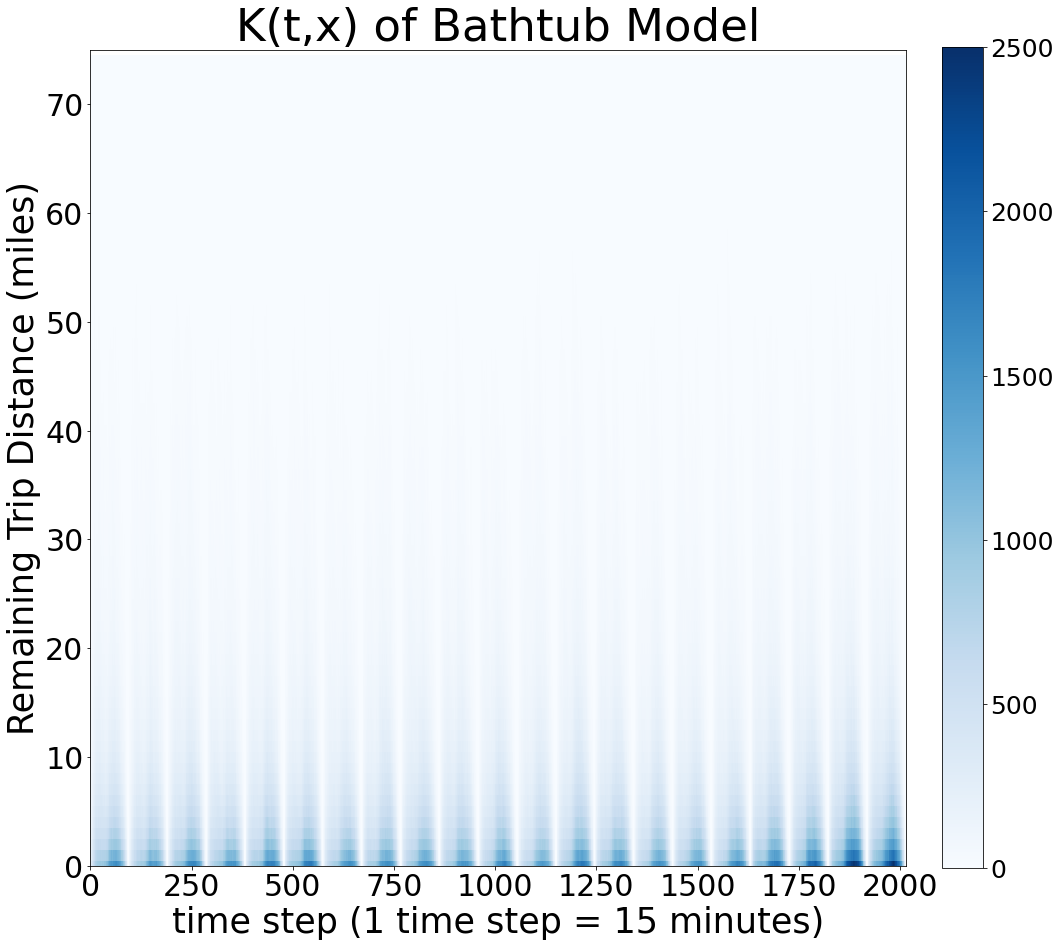

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.016919512681456417 0.028458117071673398 0.0053809082912394356 1.2554096891071533
0.00836194813866223 0.013561847851603888 0.0031620484257205723 0.8789025050855769
0.0081144626172708553 0.01314453759775034 0.0030843876367913697 0.8657483153472774
0.0063602569771370795 0.010368931518573762 0.0023515824357003977 0.7753695681912378
0.0057512172634197646 0.0097898319196443265 0.0017126026071952033 0.7579239100581736
0.005694733198288348 0.0098268131031758483 0.0015626532934008485 0.7595696468846113
0.0055240675112587347 0.0099612795821788259 0.0010868554403386439 0.7651671318543475
0.0053514255729153271 0.0099753652853201234 0.00072748586051053017 0.7659325597717822
0.00511698271420512 0.0097276217513162233 0.00050634367709401814 0.7563279708423798
0.0050488636531021529 0.0096465050484760527 0.00045122225772825338 0.7528469121272375
0.0050014633887197754 0.0095725372165230988 0.00043038956091645162 0.7497501783889974
0.0048673350122841307 0.0093220736926359314 0.00041259633193232976 0.739

0.0032420646890490351 0.0055781175895364965 0.00090601178856157332 0.5780628156527338
0.0032419480890170933 0.0055786390649451342 0.00090525711308905258 0.5780807181196392
0.0032418450595395132 0.0055779491326048676 0.0009057409864741588 0.5780291937707309
0.0032417194669441375 0.0055767249010530429 0.00090671403283523213 0.5779581748119904
0.00324133158575007 0.0055739335607817853 0.00090872961071835462 0.5778021001928711
0.003240609576603372 0.0055747540913297887 0.00090646506187695513 0.5778476463881733
0.00323934754134235 0.0055839019019830191 0.00089479318070168057 0.5783232066903919
0.0032379772886874884 0.0055862817478566215 0.000889672829518355 0.5784252038452693
0.0032364539773462831 0.0055728211812231358 0.00090008677346943024 0.5776724996134673
0.0032360010780904612 0.0055919020616245017 0.00088010009455642072 0.5786063856860911
0.0032358479825804866 0.0055924633575840654 0.00087923260757690738 0.5786636724743325
0.0032356602100724126 0.0055736823634575461 0.0008976380566872

0.0031737479279612918 0.0054354322265371315 0.00091206362938545192 0.5698686498641933
0.0031737279560538571 0.0054360180113615392 0.00091143790074617488 0.5699226467025674
0.0031736810475631733 0.0054361131796251232 0.00091124891550122347 0.5699222574426406
0.0031736250592738127 0.005435188491533299 0.00091206162701432591 0.5698739443682863
0.0031735839119405324 0.0054336838741307521 0.00091348394975031256 0.5698097451664509
0.0031734660777927438 0.0054353126049905831 0.00091161955059490454 0.569893324294696
0.0031734002226287659 0.005437124402984328 0.00090967604227320425 0.569984437666458
0.0031733381582546042 0.0054387010670077915 0.0009079752495014167 0.5700755658629111
0.0031732394012488046 0.0054378570884064809 0.00090862171409112865 0.5700251983644621
0.0031730388190004794 0.0054321199660446809 0.00091395767195627813 0.5697196723795961
0.0031729692993196727 0.0054336263224785261 0.00091231227616081912 0.5697852011621932
0.003172920109419484 0.0054336814584231424 0.00091215876041

0.0031704045079268316 0.0054289232612907386 0.00091188575456292427 0.5694955246114881
0.003170338198979702 0.005429185983023963 0.00091149041493544076 0.5694994338171719
0.0031703048211165095 0.0054308518914089965 0.00090975775082402217 0.5695832634487369
0.0031702804868157814 0.0054302714760202705 0.00091028949761129234 0.5695504656780018
0.0031702685222408837 0.0054289410700214761 0.00091159597446029117 0.5694923615875299
0.0031702538128513709 0.0054283022460458324 0.00091220537965690967 0.5694577013264819
0.0031702405128831066 0.005428440814779098 0.0009120402109871154 0.5694648374333713
0.0031702263355813552 0.0054299144405806988 0.00091053823058201172 0.5695459287343198
0.003170213603962785 0.0054294437152129834 0.00091098349271258674 0.5695247183913499
0.0031701922134716671 0.005430078047174049 0.0009103063797692854 0.5695612527500542
0.0031701609404045212 0.0054299753102062739 0.00091034657060276841 0.5695605083757918
0.0031701406080427751 0.0054300113041212076 0.000910269911964

0.0031664417327965629 0.0054238671303924232 0.00090901633520070271 0.5692133147433898
0.0031663445954181668 0.0054283337518594207 0.00090435543897691257 0.5694071090371319
0.0031662555348523839 0.0054250858396746211 0.000907425230030147 0.5692335639404857
0.0031661825720486637 0.00541751106662481 0.00091485407747251743 0.5688472977037838
0.0031661264154746521 0.0054181819509474347 0.00091407088000186934 0.5688813030267221
0.0031660643853651206 0.0054167842176750308 0.00091534455305521 0.5688028117192085
0.0031659933413830826 0.0054255802899208236 0.00090640639284534177 0.5692492674865194
0.0031658311902055141 0.0054231970173449183 0.00090846536306611017 0.5691245113965312
0.0031656408914323337 0.0054179364351425894 0.000913345347722078 0.5688240629223497
0.0031655117143485215 0.005413329918807358 0.00091769350988968475 0.5686028564394763
0.0031653523753132607 0.0054128753478939733 0.00091782940273254826 0.5685656047460832
0.0031652270409022907 0.0054134187270265107 0.000917035354778070

0.0031477096050041781 0.0053865932461734994 0.00090882596383485637 0.566986381278475
0.0031473543364774446 0.00538589034521501 0.00090881832773987879 0.5669397629469404
0.0031466355433976394 0.0053892561026111924 0.00090401498418408663 0.5671130231741219
0.0031459937994292608 0.0053879629772813362 0.00090402462157718536 0.5670457956647028
0.0031457154629014792 0.0053893607183981649 0.00090207020740479314 0.5671086596571837
0.0031455013094499147 0.0053844671552570672 0.00090653546364276229 0.5668659697626705
0.0031453564334880152 0.005385855539703964 0.00090485732727206656 0.5668572109457267
0.0031451595254237013 0.005390581820077114 0.00089973723077028868 0.5671546866626622
0.0031450611154355355 0.0053861721155303195 0.0009039501153407511 0.5669377328541341
0.0031449709964347884 0.0053901196990047244 0.00089982229386485247 0.5671445443960426
0.0031449203676218148 0.0053901449408757674 0.00089969579436786223 0.5671397564356719
0.0031448802236590688 0.0053904497211890038 0.00089931072612

0.0031087724937227316 0.0053636109574707047 0.00085393402997475834 0.5654662193621636
0.003108528128931364 0.0053575596802521094 0.00085949657761061826 0.5651660232828614
0.0031081410061785135 0.005360124938848747 0.00085615707350828 0.5653306552919429
0.0031077515431575751 0.0053558279392301421 0.00085967514708500787 0.5651309545097839
0.0031073246775707598 0.0053622568845829877 0.0008523924705585318 0.5654768256451725
0.0031069873902360907 0.0053580521655641608 0.0008559226149080204 0.5652583258319996
0.0031067840107044595 0.0053655685544974673 0.00084799946691145177 0.5656042473211637
0.0031063255297923541 0.0053601938879719044 0.00085245717161280344 0.5653450194863834
0.0031057870741057047 0.0053604713181668248 0.00085110283004458424 0.565385250451488
0.0031045484105506737 0.0053655013745964944 0.00084359544650485321 0.5656039497735466
0.0031034852360849376 0.0053663347990933457 0.00084063567307652914 0.5655662713357084
0.0031029691134086858 0.005360441709203705 0.00084549651761366

0.0030710966747075877 0.0053076607447503192 0.0008345326046648563 0.5622865499283897
0.0030710490347065668 0.005305699690012244 0.00083639837940089 0.5621830558524338
0.0030709783646770544 0.0053047304422512865 0.00083722628710282247 0.5621246375167049
0.0030708685757662832 0.0053020166625390615 0.00083972048899350461 0.5619749940429376
0.0030707492534326579 0.0053035163018906985 0.00083798220497461771 0.5620464545817316
0.0030704731005853189 0.00530359631501394 0.00083734988615669754 0.56205818821672
0.00307029025460589 0.0053062742994974908 0.00083430620971428971 0.562190075060412
0.0030700127754288544 0.0053047266852847648 0.00083529886557294443 0.5620995415957207
0.0030698164794447412 0.0053038902614659213 0.00083574269742356074 0.56205614496458
0.0030697259413828846 0.0053037076693427249 0.00083574421342304391 0.5620642097366547
0.0030696321512010257 0.0053086612998353008 0.00083060300256675038 0.5623401013380092
0.0030695682914935961 0.0053035734248470662 0.00083556315814012577 0

0.0030614999066851671 0.005271073394407487 0.00085192641896284741 0.5604172059162418
0.0030614559879434677 0.0052726930681908585 0.00085021890769607675 0.5604898176188159
0.003061413871461722 0.005272907904918629 0.00084991983800481515 0.5605125432602135
0.0030613516859841275 0.0052734795632777519 0.00084922380869050342 0.5605371461219563
0.0030612655873839606 0.0052718117102724879 0.00085071946449543333 0.5604492060471848
0.00306113263828473 0.0052692195509638157 0.00085304572560564434 0.5602893795202444
0.0030610302229591604 0.0052703275874522231 0.00085173285846609759 0.5603597667342873
0.0030607735645236116 0.0052727040564499441 0.00084884307259727872 0.5604774087919187
0.0030604985116435019 0.0052735473635762992 0.00084744965971070437 0.5605194171337882
0.0030603757466756577 0.00528211121504368 0.00083864027830763592 0.5609091861950612
0.0030601437103587796 0.0052753592399504435 0.00084492818076711536 0.5605402939544605
0.0030599835160837262 0.0052729109497660961 0.000847056082401

0.0030528142765774762 0.0052577531019832773 0.00084787545117167478 0.5596948371554974
0.003052752672995541 0.0052561123549973634 0.00084939299099371821 0.5596070298404313
0.0030527211522189961 0.0052562522361462981 0.00084919006829169369 0.5596037931917983
0.0030526869995508286 0.0052575959509060044 0.00084777804819565308 0.5596707068667747
0.0030526541577069167 0.0052562415736211029 0.00084906674179273021 0.5596078884597478
0.0030526248323211221 0.00525544643557323 0.00084980322906901462 0.5595621996831015
0.0030526089140987325 0.005256637275154654 0.00084858055304281145 0.5596297964881987
0.0030525971181102926 0.0052532214116807951 0.00085197282453979028 0.5594479269489722
0.00305259005686684 0.0052542498455126069 0.00085093026822107259 0.5595036416893048
0.0030525761595121309 0.0052545136338596077 0.00085063868516465431 0.5595225755616196
0.0030525553724222321 0.0052543586046831193 0.00085075214016134485 0.559518333393632
0.0030525207409687512 0.0052544370360414179 0.000850604445896

0.0030452520431532037 0.0052283392872527453 0.00086216479905366179 0.5581789048690475
0.0030451898142031795 0.0052285813782752093 0.00086179825013114972 0.5581897234567522
0.0030451395823793267 0.0052272567722855207 0.00086302239247313306 0.5581347480176057
0.0030450519408619127 0.0052262816795568641 0.00086382220216696154 0.5580821557534483
0.0030449716888068658 0.00522599790546621 0.00086394547214752092 0.5580634372599959
0.0030449031070542134 0.0052253144836575342 0.00086449173045089237 0.5580172497962965
0.0030448558854499113 0.0052254076225136678 0.000864304148386155 0.5580101495396116
0.0030448476973233222 0.0052237243777806955 0.00086597101686594884 0.5579334213073509
0.0030448103439667303 0.0052240095419664222 0.00086561114596703822 0.5579315344875289
0.0030447845223473533 0.0052284069340101536 0.00086116211068455327 0.5581797441521861
0.0030447114718058161 0.0052234554899472044 0.00086596745366442724 0.5579122428660315
0.0030446529509657741 0.0052248561054925383 0.000864449796

0.0030372271342208289 0.0051902041373101549 0.00088425013113150274 0.5563733447706566
0.0030370883967491646 0.0051942123080556332 0.00087996448544269625 0.5565891168717771
0.0030369532870634817 0.0051944114060297935 0.00087949516809716986 0.5565877085983475
0.0030367104546256719 0.0051887569514439185 0.00088466395780742544 0.556314702411321
0.0030364984201520242 0.0051927217507012841 0.00088027508960276425 0.5565325345355988
0.0030361100513290281 0.0051924800426789864 0.00087974005997906995 0.5565481670193512
0.0030359526598693512 0.0051884455824750854 0.00088345973726361719 0.5563264512814596
0.0030358256857107584 0.0051909143347503078 0.00088073703667120918 0.5564811362039247
0.003035688942403286 0.0051932690206589818 0.00087810886414759024 0.5566130428547676
0.0030355645249625736 0.0051975361097805935 0.00087359294014455354 0.556832967115123
0.0030353183050120854 0.0051865141199995126 0.00088412249002465821 0.556226394413264
0.0030352159284830465 0.0051843674281742578 0.000886064428

0.0030195874040154815 0.0051543901953033881 0.00088478461272757441 0.5543977695912455
0.0030195469217148938 0.0051506911995744436 0.00088840264385534377 0.554194658618972
0.0030195135127681913 0.00515196746317892 0.00088705956235746229 0.5542697280309817
0.0030194838997572777 0.0051530918848898995 0.0008858759146246558 0.5543208320908407
0.00301944189882283 0.0051564537025160818 0.000882430095129578 0.5545015996412888
0.0030193960001737375 0.0051569773820998961 0.00088181461824757854 0.5545230458596903
0.0030193299284653179 0.0051580527345307988 0.00088060712239983738 0.5545787245523457
0.0030192075907986187 0.0051589794822630647 0.00087943569933417241 0.5546224752246025
0.0030190286084109323 0.0051591445447950659 0.00087891267202679893 0.5546276098214478
0.0030188577985182522 0.0051581073658509332 0.00087960823118557138 0.554554787524221
0.0030188158368826337 0.0051615639605719485 0.00087606771319331941 0.55476012163447
0.0030186604684512551 0.0051585727575676676 0.0008787481793348424

0.0030076959613058018 0.00513209223756273 0.000883299685048873 0.5533019925066106
0.0030076599317589523 0.0051338051114933874 0.000881514752024517 0.5533818015906316
0.0030076307265159514 0.0051336547360431237 0.000881606716988779 0.5533606173270159
0.0030076122545527437 0.0051344876976350609 0.00088073681147042679 0.5533987008873862
0.0030075745782026445 0.0051350952699137295 0.0008800538864915593 0.5534202932765805
0.0030075502997317263 0.0051351523650184534 0.00087994823444499952 0.553425056652853
0.0030075240897164766 0.0051348078108977091 0.000880240368535244 0.5534080503381774
0.0030074928501468839 0.0051345193552264513 0.00088046634506731673 0.5534026833431073
0.0030074464761848836 0.0051337870646959117 0.00088110588767385562 0.5533689056692735
0.0030073751224903786 0.0051330401044993564 0.0008817101404814011 0.5533487934729089
0.0030073102635097279 0.0051318924493252722 0.00088272807769418414 0.553279079024262
0.00300724797114285 0.0051315208943207048 0.000882975047964995 0.553

0.0030012261779732105 0.0051286461559801513 0.00087380619996626932 0.553037983087433
0.0030011581748369438 0.005125403774461355 0.00087691257521253221 0.5528780017378996
0.0030010811367911856 0.005122022989721948 0.00088013928386042317 0.5526966333457254
0.0030010110817013996 0.0051205858316149639 0.00088143633178783547 0.5526385685396407
0.0030009024184196181 0.0051215471378565818 0.00088025769898265448 0.5526777612844122
0.0030008087086620572 0.0051238511286277912 0.000877766288696323 0.5527993209708904
0.0030006649270089133 0.0051244668732619708 0.000876862980755856 0.5528265865138305
0.003000537432035461 0.0051267457067183889 0.00087432915735253321 0.5529637432823552
0.0030004517533556278 0.0051249803874514549 0.00087592311925980041 0.5528620630041985
0.0030003551231305172 0.0051229759979030814 0.000877734248357953 0.5527583703769945
0.0030002691454592877 0.0051214800299028192 0.00087905826101575594 0.5526636740206375
0.0030002175641270852 0.0051238433866353248 0.000876591741618845

0.0029945352140070595 0.0050995771043850086 0.00088949332362911026 0.5514907378195292
0.0029945021784349578 0.0051008401194375238 0.00088816423743239155 0.5515534537238747
0.0029944811597420883 0.0051004464431518345 0.00088851587633234218 0.5515294067765619
0.0029944426890455319 0.005099887797797853 0.00088899758029321126 0.5515029282033089
0.0029943634860624727 0.0050983138806586234 0.00089041309146632209 0.5514266747227443
0.0029942864870451218 0.0050979563926216651 0.00089061658146857847 0.5514150917795888
0.0029941605693209637 0.0050962263760703256 0.00089209476257160218 0.5513185761028304
0.0029940413301854196 0.0050993774298626554 0.00088870523050818388 0.5514808696459429
0.0029939661938117148 0.00510037933752196 0.00088755305010146878 0.5515169424527316
0.00299391717881024 0.00509913651629023 0.00088869784133025008 0.5514637320884048
0.0029938755639424362 0.0050981161165023891 0.00088963501138248312 0.5514124090005705
0.0029938249945781928 0.0051010847361511067 0.000886565253005

0.0029912419107274175 0.0051000197923536028 0.00088246402910123207 0.5515018702653343
0.0029912204455864837 0.005099174977245385 0.00088326591392758232 0.5514619993453103
0.0029911993980145609 0.0050984733591555968 0.00088392543687352523 0.5514294825535345
0.0029911859359244438 0.0050990441084508443 0.00088332776339804318 0.5514521597613949
0.0029911652499606143 0.0050986198488407195 0.000883710651080509 0.5514365949985947
0.0029911528342884564 0.0050994321581883878 0.00088287351038852523 0.5514784185382257
0.0029911437040727575 0.0050990287350262 0.00088325867311931478 0.5514554210060356
0.0029911382153795883 0.0050988036168301719 0.00088347281392900422 0.5514453817118665
0.0029911323824946935 0.0050986112703103794 0.0008836534946790078 0.5514347577340637
0.0029911270399029634 0.0050980195429965406 0.00088423453680938581 0.5514066725798656
0.0029911209612875078 0.0050975511718460284 0.00088469075072898683 0.5513831539432813
0.0029911159654492712 0.005097238598974 0.0008849933319245423

0.0029887097341954904 0.0050874566345065157 0.00088996283388446506 0.5508927631141043
0.00298868652699983 0.0050881989077737437 0.000889174146225916 0.5509256448794836
0.0029886515334163442 0.0050897209769388682 0.00088758208989382008 0.5510084066595796
0.0029886188042875027 0.0050884374924023475 0.000888800116172658 0.5509445743096985
0.0029885981669983061 0.0050871715434588584 0.00089002479053775375 0.5508700197060464
0.0029885674967012935 0.005087494328348938 0.000889640665053649 0.5508840683610737
0.0029885464257187007 0.0050872926290018109 0.00088980022243559 0.550889921009828
0.0029885309171945877 0.00508758249050633 0.00088947934388284547 0.5509028527300989
0.0029885025881779942 0.0050863901689173633 0.000890615007438625 0.5508398256909266
0.0029884897569122247 0.0050871129255243668 0.0008898665883000827 0.5508884072368924
0.0029884635999445817 0.0050858746921795851 0.00089105250770957851 0.5508212912806149
0.0029884496704434011 0.0050866782788519345 0.00089022106203486744 0.550

0.0029871474172683981 0.005086103312836693 0.00088819152170010324 0.5508519376464293
0.0029870933471492448 0.0050875426420929487 0.000886644052205541 0.5509168139762513
0.0029870496862131673 0.0050864344081355843 0.00088766496429075047 0.5508387347624225
0.0029870115353595166 0.0050875828694871648 0.00088644020123186847 0.550901976764374
0.0029869704829179615 0.0050869091388991193 0.00088703182693680358 0.5508740839573127
0.0029869421171273519 0.0050864885280656634 0.00088739570618904032 0.5508476886062489
0.0029869202833916549 0.0050847619753669046 0.000889078591416405 0.5507553949645185
0.0029869101812577581 0.0050855945175878482 0.00088822584492766828 0.5508114981834806
0.0029869050758752451 0.0050853106670516995 0.0008884994846987906 0.5507887747180165
0.0029868911454539243 0.0050848585904340621 0.00088892370047378619 0.5507701068864859
0.0029868842458508297 0.00508609995911327 0.00088766853258838961 0.5508351704107284
0.002986874062549633 0.005085611487467224 0.000888136637632042 

0.0029856609552215696 0.0050793809058258853 0.00089194100461725378 0.5504654649318061
0.0029856475365458435 0.0050785701264639081 0.00089272494662777867 0.5504064639843802
0.0029856038792063781 0.0050804675768954932 0.00089074018151726313 0.5505128878846263
0.0029855724871003194 0.0050806845531204117 0.00089046042108022747 0.5505262348444148
0.002985538009691817 0.0050800240874295062 0.00089105193195412782 0.5504905353283808
0.0029855190810160258 0.0050800366715576554 0.0008910014904743959 0.550494939097994
0.0029854999927691915 0.0050764199589806158 0.00089458002655776745 0.5503092858941161
0.0029854727308549272 0.0050774238691395834 0.00089352159257027127 0.5503382906254404
0.0029854248943253755 0.0050771660090495867 0.00089368377960116427 0.5503307124299415
0.0029853840313404517 0.0050768329923411354 0.00089393507033976851 0.5503226100687978
0.0029853420060448844 0.0050759709886634185 0.00089471302342635048 0.5502744945333202
0.0029853021081288453 0.0050778738890031308 0.00089273032

0.0029836617868868993 0.0050768068616273941 0.00089051671214640418 0.5503373221873635
0.002983640001190974 0.0050783650752396717 0.00088891492714227613 0.5504269951286851
0.0029836245407703719 0.0050784536783140327 0.00088879540322671087 0.5504246325389631
0.002983610183443982 0.005078228520065807 0.00088899184682215688 0.55041188762464
0.0029835951728380233 0.00507797940775772 0.00088921093791832718 0.5503958570182248
0.0029835677679444319 0.0050775361524291948 0.00088959938345966889 0.5503685425694765
0.0029835419693577331 0.0050767252123155018 0.00089035872639996432 0.5503113199518898
0.0029835270101910795 0.005076407633741703 0.00089064638664045591 0.550306400405726
0.0029835045421321149 0.00507603368563956 0.00089097539862467018 0.5502767705608552
0.0029834938253204537 0.0050770477804381493 0.00088993987020275856 0.5503294271111591
0.0029834719660326932 0.0050785417281390081 0.00088840220392637811 0.5504125173611126
0.0029834598668557286 0.0050794193316304088 0.0008875004020810481

0.0029823114637022225 0.0050777886015306046 0.0008868343258738408 0.5504143192042156
0.0029822923934852271 0.0050784781915812136 0.00088610659538924041 0.5504538725146582
0.0029822648135361422 0.0050774455975884378 0.000887084029483847 0.550391171846614
0.0029822381122418845 0.0050783921931494575 0.00088608403133431143 0.550429867377056
0.0029822169752701912 0.0050788568204208576 0.00088557713011952477 0.5504604898482782
0.0029821848562668011 0.0050773860837955 0.00088698362873810231 0.5503777919918864
0.0029821335495331266 0.0050765631019652922 0.00088770399710096115 0.5503291003301825
0.0029820856210332498 0.0050777323925654452 0.00088643884950105438 0.5504108808998146
0.002982055792534976 0.0050739331189581186 0.00089017846611183287 0.5501874241843704
0.0029820142682188064 0.0050765939767373029 0.00088743455970031 0.5503340349942258
0.0029819822170306697 0.005076406155627545 0.000887558278433794 0.5503316038053276
0.00298195349804208 0.0050764978054115969 0.00088740919067256327 0.55

0.0029802304201848023 0.0050720957530629709 0.00088836508730663318 0.5500692129763831
0.0029801930545523729 0.005068585494963241 0.000891800614141505 0.5498754859886713
0.0029801707200031945 0.005070988653746826 0.00088935278625956271 0.5499918459533594
0.0029801285088919662 0.0050710864414893744 0.00088917057629455819 0.55001024396554
0.0029801063779742796 0.0050719182722871008 0.0008882944836614583 0.5500596884703913
0.0029800852800419557 0.0050714297775681528 0.00088874078251575874 0.5500254425551732
0.0029800685845551905 0.0050716435142131016 0.00088849365489727938 0.5500372993848023
0.0029800479192996269 0.0050710717100132773 0.00088902412858597659 0.5500107263999937
0.0029800304746406278 0.0050714924998783639 0.00088856844940289181 0.5500353803623333
0.0029800033831764751 0.005069888372101301 0.00089011839425164909 0.5499484000376037
0.002979973111752925 0.0050715847285609308 0.00088836149494491909 0.5500337120128698
0.002979954922122842 0.0050708529893888615 0.000889056854856822

0.0029785169839414462 0.0050696119656863121 0.00088742200219658 0.5499505266172403
0.0029785020520449674 0.0050705263207407817 0.00088647778334915344 0.550002123766095
0.0029784910931015831 0.0050682484663602013 0.000888733719842965 0.5498774020181374
0.0029784715008318915 0.0050702353256148955 0.000886707676048887 0.5499801595928335
0.0029784596492186685 0.00507134769883926 0.000885571599598077 0.5500494567520156
0.0029784423159510856 0.0050698609704427286 0.00088702366145944225 0.5499580287756081
0.0029784275892404686 0.0050695111436680788 0.00088734403481285809 0.5499371513878688
0.0029784136000699539 0.0050699307004110107 0.00088689649972889658 0.5499585881423696
0.0029784068080371752 0.0050695984455919 0.00088721517048245054 0.5499359145323618
0.002978396819008515 0.0050700581641205016 0.00088673547389652872 0.5499651837044581
0.002978385133548147 0.005070241705153267 0.00088652856194302719 0.5499811619817512
0.002978374557555937 0.0050715141923420633 0.00088523492276981091 0.5500

0.0029771507613554926 0.00506856966583263 0.00088573185687835533 0.5499361662200594
0.0029771466612360147 0.0050682063411505961 0.00088608698132143331 0.5499190575207628
0.0029771410955144462 0.0050680499632422254 0.00088623222778666728 0.5499106132831515
0.0029771372839389543 0.0050670974434134531 0.00088717712446445584 0.5498603448833821
0.0029771273712777737 0.0050677207488798821 0.000886533993675665 0.5498859651920546
0.0029771178453762903 0.0050680385983877235 0.00088619709236485733 0.5499045567654398
0.0029771083210048672 0.0050680445322864517 0.00088617210972328283 0.5499041224550547
0.0029770965227946043 0.0050703120223441851 0.00088388102324502341 0.5500082854895388
0.0029770721309815519 0.0050683676030439748 0.00088577665891912858 0.5499192599776552
0.0029770527074757637 0.0050677344483249214 0.00088637096662660627 0.5498900650499702
0.0029770173704204918 0.0050666273580387841 0.00088740738280219955 0.5498387412614085
0.002977002976042629 0.0050668252797765271 0.0008871806723

0.0029757681935431834 0.0050614364200136331 0.0008900999670727333 0.5495485449476232
0.0029757531795918395 0.0050620872249681741 0.00088941913421550461 0.5495851259258941
0.0029757434756505258 0.0050620410340598233 0.0008894459172412286 0.5495805929993597
0.0029757391143143382 0.0050627565919061489 0.00088872163672252744 0.5496282916601778
0.0029757294302081767 0.0050628715322268954 0.00088858732818945785 0.5496220732589784
0.0029757259429406286 0.0050620007570997081 0.00088945112878154921 0.5495733548335275
0.0029757223589862098 0.0050623844216005241 0.00088906029637189513 0.5495944098304703
0.002975719782066925 0.0050626821333996895 0.00088875743073416047 0.5496097395733044
0.0029757168936767834 0.0050626051462438846 0.00088882864110968187 0.5496058880916082
0.0029757126520424284 0.0050624591406944726 0.00088896616339038438 0.5495975842043443
0.0029757071776280479 0.00506222399111206 0.00088919036414403609 0.5495864358449599
0.0029757022092047705 0.0050614626674357083 0.0008899417509

0.0029746162158256918 0.0050595414064078031 0.00088969102524358019 0.5494451546343609
0.002974609589882978 0.0050595857119821314 0.00088963346778382483 0.5494447071751317
0.0029746037526576985 0.0050601120774416836 0.000889095427873713 0.5494717792330844
0.002974598418728866 0.0050604411341668622 0.00088875570329086931 0.5494879499675124
0.0029745937985844228 0.0050607881660416605 0.00088839943112718484 0.5495082299882745
0.0029745887485472474 0.0050610733622282883 0.00088810413486620676 0.5495266260288281
0.0029745830121562121 0.0050606747014106217 0.000888491322901802 0.5495040963141814
0.0029745764185694088 0.0050601472332876714 0.00088900560385114606 0.5494762932211391
0.0029745726043846686 0.005059870517897397 0.00088927469087194 0.5494565524856894
0.0029745672867743473 0.0050601908740465721 0.00088894369950212279 0.5494745586882038
0.0029745596469174574 0.0050603271647548338 0.00088879212908008084 0.5494812912263047
0.0029745476502809247 0.0050613613770198159 0.000887733923542033

0.0029736325486296638 0.0050566877334948255 0.00089057736376450228 0.5492939309673052
0.0029736248200066566 0.00505700676673898 0.00089024287327433378 0.5493153724644916
0.0029736147742430888 0.0050575114799245053 0.00088971806856167246 0.5493464921432092
0.0029736109861486434 0.0050577205992525607 0.00088950137304472641 0.5493760162924334
0.002973601850099432 0.005057203956469981 0.000889999743728883 0.5493400202083446
0.00297359662932582 0.0050572939490250686 0.00088989930962657144 0.5493419083600005
0.0029735901175441596 0.0050572000321386515 0.00088998020294966766 0.5493368260267688
0.0029735880169198935 0.00505655992740151 0.00089061610643827659 0.5493020549615535
0.0029735834768975979 0.005056920401340181 0.00089024655245501514 0.5493254830846616
0.0029735806880925217 0.0050570011622494294 0.0008901602139356141 0.549329469218085
0.0029735770754650251 0.0050572354925086929 0.000889918658421357 0.5493446005603382
0.0029735746397949758 0.005057068533274158 0.00089008074631579379 0.5

0.0029727880268305114 0.0050585616053454487 0.00088701444831557411 0.549419373033419
0.0029727784224093008 0.005058376386891451 0.00088718045792715073 0.5494105472165552
0.0029727705806833165 0.0050582987742453667 0.00088724238712126658 0.5494060519290185
0.0029727652730090278 0.0050589527939244559 0.00088657775209359947 0.5494414565937454
0.0029727592705554567 0.0050589599952965162 0.0008865585458143969 0.5494382831596825
0.0029727566030533694 0.0050593754853214372 0.00088613772078530129 0.5494643029473971
0.00297275245573824 0.0050593956153151196 0.00088610929616136079 0.5494632259560773
0.0029727491173832886 0.005058957237838343 0.00088654099692823452 0.5494402250409508
0.0029727453893695307 0.0050586818163249128 0.0008868089624141487 0.5494254982127361
0.0029727424029508441 0.005058527508512752 0.00088695729738893581 0.5494197974195586
0.0029727405793898275 0.0050585048904090504 0.00088697626837060443 0.5494165147965426
0.0029727385016222129 0.0050585798124668443 0.0008868971907775

0.0029722687237542672 0.0050595311628115246 0.0008850062846970097 0.5494962433088854
0.0029722585428841909 0.0050606367004879856 0.00088388038528039643 0.5495461225222766
0.0029722536331229696 0.0050601756290139677 0.00088433163723197154 0.5495198726699592
0.0029722428126916795 0.0050600803957005554 0.00088440522968280359 0.5495107457757648
0.0029722356760051465 0.0050608071386098567 0.00088366421340043614 0.5495568219003677
0.0029722290347719777 0.0050604343220099889 0.00088402374753396632 0.5495329003807172
0.002972221619041873 0.00506047530787894 0.00088396793020480548 0.5495369750608696
0.002972217293120135 0.0050604644612699239 0.00088397012497034623 0.5495400441897265
0.0029722083575624185 0.0050598189041541142 0.00088459781097072242 0.5495106122828988
0.0029721988147842528 0.0050604918353025705 0.000883905794265935 0.549544368455634
0.0029721881591371338 0.0050599808245882262 0.00088439549368604143 0.5495218209915115
0.0029721776195471205 0.0050602696516956775 0.0008840855873985

0.0029712190271207594 0.00505506493851869 0.00088737311572282878 0.5492398112324375
0.0029712073663694261 0.0050537166766501463 0.00088869805608870567 0.5491711402270562
0.0029711948348348409 0.0050544727270129325 0.00088791694265674909 0.5492067221007194
0.0029711779758335236 0.0050549283847726445 0.00088742756689440261 0.5492273040814386
0.0029711486303067676 0.0050543621259693493 0.00088793513464418563 0.5492061422391855
0.0029711150198516779 0.00505886499557895 0.000883365044124406 0.5494775735217801
0.0029710751658141177 0.005056648059870817 0.00088550227175741847 0.5493386004117834
0.0029710464700692975 0.0050547518019621656 0.00088734113817642954 0.549242831861458
0.0029710115965905157 0.0050525100980776524 0.00088951309510337871 0.5491048544492201
0.0029709823922499027 0.0050564124516830379 0.0008855523328167677 0.5493233107783031
0.0029709608844661803 0.00505565752811209 0.00088626424082027008 0.5492984303301748
0.0029709473303037911 0.0050540901311387065 0.0008878045294688758

0.0029704270782805338 0.005057036144154519 0.00088381801240654842 0.5493565122529177
0.0029704192892896293 0.005056028830402644 0.00088480974817661449 0.5493020990609389
0.0029704128456972435 0.0050552117977478751 0.000885613893646612 0.549267749968622
0.0029704052492992615 0.00505586967363873 0.00088494082495979326 0.5492919717384764
0.0029703994198301345 0.0050565636253903758 0.00088423521426989288 0.5493316075824852
0.0029703931163393782 0.0050567259925819417 0.00088406024009681481 0.5493403765441771
0.0029703867285364948 0.005056871225200885 0.00088390223187210452 0.5493445538384921
0.0029703808049514014 0.0050567374005373285 0.00088402420936547447 0.5493414193201405
0.0029703776632512709 0.0050562814837591475 0.00088447384274339448 0.5493165877004659
0.0029703756105034394 0.0050563116263676062 0.00088443959463927228 0.549320831996666
0.0029703740170464879 0.0050565005855142762 0.00088424744857869969 0.5493296691009973
0.0029703709818358079 0.0050568062325213013 0.00088393573115031

0.0029696395399070271 0.00505478194677736 0.00088449713303669422 0.5492826957657441
0.0029696365786379656 0.005054613452684628 0.00088465970459130283 0.5492686823062475
0.0029696338631767785 0.0050545646178968224 0.00088470310845673429 0.5492688854466188
0.00296963126111559 0.0050545109726522833 0.00088475154957889663 0.5492667013134225
0.002969626501911364 0.0050542755581965615 0.00088497744562616673 0.5492530785531716
0.0029696243553910956 0.0050546062636941166 0.00088464244708807472 0.5492728480797485
0.0029696224370590815 0.0050547302298671829 0.00088451464425098035 0.5492762202932098
0.0029696161263466758 0.0050550425986373645 0.00088418965405598674 0.5492963388802249
0.0029696065170421206 0.0050555900528175442 0.00088362298126669673 0.5493252459914474
0.0029695976712511814 0.0050564436644891433 0.00088275167801321922 0.5493722703948604
0.0029695877591100145 0.0050560051425129647 0.00088317037570706481 0.5493481799832401
0.0029695785029500306 0.0050559160688666664 0.00088324093703

0.0029682255515553835 0.0050520743995747163 0.00088437670353605036 0.5491725510655835
0.0029682148162287134 0.0050522703454472448 0.00088415928701018225 0.549179732575211
0.0029682069484359857 0.0050523534093695555 0.0008840604875024156 0.5491826773030676
0.0029681995761503279 0.00505209604812016 0.0008843031041804965 0.5491730300177856
0.0029681932853789675 0.00505294766586806 0.00088343890488987479 0.5492119932482659
0.0029681853481767955 0.005052352992128359 0.00088401770422523169 0.5491871416321593
0.0029681772840060025 0.0050518403599730437 0.00088451420803896115 0.5491594382132379
0.0029681620836171452 0.005051488117506755 0.000884836049727535 0.5491459379877552
0.0029681593433525159 0.0050514865525842743 0.00088483213412075747 0.5491510205966711
0.0029681486195345173 0.0050531726582788523 0.00088312458079018211 0.5492549703328476
0.0029681190823627277 0.0050495612424023 0.00088667692232315609 0.54904296288414
0.0029681152750634932 0.005053021593671078 0.00088320895645590863 0.54

0.0029669134562947974 0.0050481784282082609 0.00088564848438133382 0.5489487288434818
0.0029669009705119011 0.0050481445625169576 0.00088565737850684434 0.5489449799102822
0.0029668804047513703 0.005046735001688593 0.00088702580781414744 0.5488787802324967
0.0029668686311837035 0.00504715435949521 0.00088658290287219694 0.5489041682193507
0.0029668578727829473 0.005046750806208769 0.00088696493935712514 0.5488830625513973
0.00296684986382531 0.0050469348738403069 0.00088676485381031288 0.5488946470458357
0.0029668322119077144 0.0050460299504627784 0.00088763447335265 0.5488441067767745
0.00296682262126754 0.0050483713225042458 0.0008852739200308344 0.5489705223814975
0.0029668154014093166 0.005048330261056444 0.00088530054176218882 0.5489760903406727
0.0029668022084621023 0.0050475746004837807 0.00088602981644042382 0.5489324230623895
0.0029667972250224071 0.0050472767253304232 0.00088631772471439154 0.5489158280727844
0.0029667900908966413 0.0050479270208019589 0.00088565316099132327 

0.0029661072783236731 0.0050471695240282347 0.00088504503261911107 0.548906867344313
0.0029661023602464568 0.00504651735484814 0.00088568736564477316 0.5488599401655319
0.0029660963295142632 0.0050468672719708113 0.000885325387057715 0.5488837480624473
0.0029660941146896552 0.0050466255895521986 0.00088556263982711165 0.5488728129240534
0.0029660906753970549 0.0050465211058004188 0.00088566024499369116 0.5488688890163326
0.0029660877485635576 0.0050462290323588788 0.00088594646476823592 0.5488524951847134
0.0029660835789961822 0.0050462905972408463 0.00088587656075151777 0.5488537814623208
0.0029660793234228752 0.00504635497833711 0.00088580366850863962 0.5488572625698644
0.0029660768718064051 0.0050467429452064182 0.00088541079840639221 0.5488768739631145
0.0029660725646739258 0.0050472859114627172 0.000884859217885134 0.5489053241276196
0.0029660661750211389 0.0050479817156445133 0.00088415063439776424 0.5489410214319951
0.002966062333563323 0.0050485645000380554 0.000883560167088590

0.0029654912944270897 0.00504618627711346 0.0008847963117407197 0.5488408611270843
0.0029654835804813224 0.0050460554657961393 0.000884911695166505 0.5488397190466322
0.0029654748243322813 0.0050463323657550805 0.00088461728290948217 0.5488518938858428
0.0029654595499255042 0.0050466360126245613 0.00088428308722644669 0.5488661408685106
0.00296545292781697 0.0050472180280824964 0.00088368782755144347 0.5488833769740239
0.0029654376281077048 0.0050476475027792043 0.000883227753436205 0.5489181321033052
0.0029654298701367958 0.00504716218221626 0.00088369755805733149 0.5488913043844612
0.00296541808189301 0.0050463939514994293 0.00088444221228659091 0.5488472474933891
0.002965413292093017 0.005047450164400679 0.00088337641978535476 0.5489044424150756
0.0029654007177554588 0.0050466365962821705 0.00088416483922874693 0.5488599833073081
0.0029653931951416617 0.0050472423211498805 0.00088354406913344278 0.5488865454331531
0.0029653816533465791 0.005046711560555109 0.000884051746138049 0.548

0.002964416595817847 0.0050436513134877077 0.00088518187814798594 0.5487392069824912
0.0029644028963019277 0.0050432289655545333 0.00088557682704932215 0.5487181914916617
0.0029643823425040609 0.0050430663623698838 0.00088569832263823815 0.548709729803325
0.0029643529322098683 0.0050436985691027815 0.00088500729531695529 0.5487398787021908
0.0029643284937310821 0.0050479550480704762 0.00088070193939168793 0.5489505103302259
0.0029642945326013581 0.0050443847186810937 0.00088420434652162225 0.5487626112360978
0.0029642870669666465 0.0050437397123763231 0.00088483442155696992 0.5487258048369958
0.0029642715997648932 0.0050450005894540958 0.0008835426100756911 0.548811040264485
0.0029642449959981347 0.0050462162603148834 0.000882273731681386 0.5488730266654572
0.0029642313319934365 0.0050465951142699521 0.00088186754971692133 0.5488934233976528
0.0029642036997363629 0.0050464302127750035 0.000881977186697722 0.548880941173584
0.0029641933391616041 0.0050467982236622848 0.00088158845466092

0.002963453703862572 0.0050455581643325548 0.00088134924339258866 0.548839562422706
0.0029634498208017169 0.0050466947018260738 0.00088020493977735987 0.5489008653365643
0.0029634335742424918 0.0050465019040686933 0.00088036524441628987 0.5488844885505353
0.0029634233802513753 0.0050462068110587073 0.00088063994944404358 0.5488726903700233
0.00296341605111586 0.0050462614278605792 0.00088057067437114151 0.5488706397939622
0.0029634129023609276 0.0050467454086978794 0.000880080396023976 0.5489078767762948
0.0029634105743983345 0.0050459928267427142 0.00088082832205395474 0.5488660093508259
0.0029634079027102771 0.0050466035451174358 0.00088021226030311859 0.5488923750133601
0.0029634061764839616 0.0050465687727533938 0.00088024358021452926 0.5488936606988927
0.0029634047326063625 0.0050463618340605369 0.00088044763115218794 0.548885445054912
0.0029634023080248122 0.005046261664556898 0.00088054295149272608 0.5488802556223024
0.002963399233616056 0.0050461452110467384 0.00088065325618537

0.0029625020973788651 0.0050385527728587292 0.00088645142189900121 0.5485161296539667
0.0029624832473882081 0.0050382494347827149 0.0008867170599937015 0.548502780579267
0.00296246819301432 0.0050384791365762661 0.0008864572494523738 0.5485072225470582
0.0029624674310875865 0.0050405604576785595 0.00088437440449661334 0.5486297759702001
0.0029624502219438805 0.0050410521852967466 0.00088384825859101428 0.5486473399050928
0.0029624414264445933 0.005039870342163565 0.00088501251072562142 0.5485865704034611
0.0029624352994499564 0.0050405968374722162 0.00088427376142769681 0.5486248334800324
0.0029624282293102492 0.0050416451000586376 0.00088321135856186039 0.5486817362788429
0.002962424682844775 0.0050418532933539 0.00088299607233564988 0.54869099561861
0.0029624206891600362 0.0050416530787215433 0.00088318829959852939 0.5486799773166946
0.0029624129617608626 0.0050409876161477789 0.000883838307373946 0.5486466748613853
0.0029624060951630531 0.0050401521326561291 0.0008846600576699773 0.

0.0029611669810328438 0.0050331958489588562 0.00088913811310683112 0.548335943454675
0.0029611611915385375 0.0050333029631041458 0.00088901941997292927 0.5483438720762517
0.0029611524673445466 0.0050335367042111589 0.00088876823047793444 0.5483561783969747
0.002961139620360609 0.0050338651424430792 0.0008884140982781389 0.54837962350482
0.0029611146919874274 0.0050341339981867352 0.00088809538578811986 0.5484041534782915
0.0029610866435579846 0.0050352214906739749 0.00088695179644199447 0.5484634351107899
0.0029610716475518112 0.0050347439702185222 0.00088739932488510014 0.5484533051204292
0.0029610603564613597 0.0050344785400350447 0.00088764217288767446 0.5484194116526419
0.0029610505515848223 0.0050357379035588287 0.0008863631996108162 0.5484865709248815
0.0029610271830050015 0.0050349478002947165 0.00088710656571528617 0.5484546741130719
0.0029610136915912523 0.0050352222467943469 0.00088680513638815788 0.5484726526875089
0.002960991311645986 0.0050340284692370124 0.000887954154054

0.0029579946517789162 0.00502480399556267 0.00089118530799516275 0.5480708396638887
0.0029579229440862553 0.005025337996649025 0.00089050789152348526 0.548098396637611
0.0029578641722306743 0.0050275580500321821 0.00088817029442916668 0.5482119680921438
0.0029577996444746257 0.0050243747111646184 0.00089122457778463278 0.5480584192528495
0.0029577838269506176 0.0050260440325302826 0.00088952362137095277 0.5481708123682744
0.0029577401759910693 0.0050268517289530443 0.00088862862302909417 0.5482036872132181
0.0029577210965695704 0.0050271481027820012 0.00088829409035714 0.5482159492176246
0.0029577105507499982 0.0050278147477395892 0.00088760635376040745 0.5482492045651318
0.0029577024049379608 0.0050273531628551669 0.00088805164702075463 0.5482178136174354
0.0029576902460105988 0.0050272373963184914 0.00088814309570270616 0.5482092736902335
0.00295765979360052 0.0050276809114215169 0.00088763867577952289 0.5482300083310976
0.0029576469497963522 0.0050272822376934007 0.00088801166189930

0.0029535765178336166 0.005036600381989091 0.00087055265367814191 0.5486948238952308
0.0029534884032333536 0.0050365563908061177 0.00087042041566058918 0.5487018800123642
0.0029532847001692958 0.005037043835715997 0.00086952556462259445 0.5487541716497876
0.0029531554803812585 0.0050367481837398859 0.00086956277702263107 0.5487283582165267
0.0029530500062977284 0.0050362049816850595 0.00086989503091039759 0.5486957736344922
0.0029528603464266134 0.0050414790140743656 0.000864241678778861 0.5489588078391372
0.0029527513245783681 0.0050369876673710305 0.00086851498178570582 0.5487230042969884
0.0029526777224836518 0.005036233112013541 0.00086912233295376228 0.5487342722717137
0.0029525793529815315 0.005039060022713134 0.0008660986832499289 0.5488676416040877
0.002952552877014672 0.005037586672632894 0.0008675190813964501 0.5487761637330495
0.0029524593979510681 0.0050372428259567534 0.00086767596994538263 0.5487641157539447
0.0029524523678966445 0.0050367873102627938 0.000868117425530495

0.00294870268366815 0.0050283299504955215 0.00086907541684077833 0.5483534739037869
0.002948680326432483 0.0050277944233628278 0.00086956622950213832 0.5483233691285775
0.0029486563967062247 0.0050276836552980951 0.0008696291381143545 0.5483169457589032
0.0029486238450092133 0.0050277521602691486 0.00086949552974927816 0.5483156031172173
0.0029485848981376296 0.0050282294091141336 0.00086894038716112522 0.548340068496786
0.0029485342867663681 0.0050293796765945266 0.00086768889693820983 0.548399521981164
0.0029484743199151161 0.0050310482526116215 0.00086590038721861087 0.5485074400155872
0.0029484049955282843 0.0050300841814313576 0.00086672580962521132 0.5484535541920411
0.002948305714429163 0.0050282008721576933 0.000868410556700633 0.5483686106567621
0.0029482064905193236 0.005026784705031039 0.00086962827600760826 0.5483024205004692
0.0029481505996823915 0.0050276810120493129 0.00086862018731546974 0.5483556109882942
0.0029481028596661774 0.0050263837655150365 0.000869821953817318

0.0029448582282248 0.0050166905341924714 0.00087302592225712856 0.5477148746974522
0.0029448378400951433 0.0050153363450975187 0.00087433933509276768 0.5476334790995742
0.0029448169324243862 0.0050145509632226375 0.0008750829016261352 0.5475957265647621
0.0029447932740023783 0.0050147655384021605 0.00087482100960259619 0.5476102000205886
0.0029447765323125097 0.0050152272702212843 0.00087432579440373465 0.5476350497844267
0.0029447529988778573 0.0050130313627185213 0.00087647463503719343 0.5475190298812367
0.0029447317517385624 0.0050133964000564609 0.00087606710342066408 0.5475303496447709
0.0029447046605471875 0.0050132638444616165 0.00087614547663275848 0.5475312134044305
0.0029446672914209206 0.00501327566155502 0.0008760589212868209 0.5475328642229953
0.0029446368174969625 0.0050131330471949427 0.00087614058779898231 0.5475218008290429
0.0029445968722097361 0.0050136408339444818 0.00087555291047499079 0.5475561930378074
0.0029445377769942898 0.0050131566029015867 0.000875918951086

0.0029413224288758542 0.0049978372623965218 0.00088480759535518642 0.5468837963495184
0.0029412820580485611 0.0049966832258838481 0.0008858808902132741 0.5468255317029911
0.0029412161718523539 0.0049952818672807367 0.0008871504764239712 0.5467522749203467
0.0029411795840891043 0.004994562133803406 0.00088779703437480287 0.5467095943898219
0.0029411588134659358 0.0049951170094217614 0.00088720061751011009 0.5467312993459904
0.0029411377935534707 0.0049942626896219647 0.0008880128974849764 0.5466714612144217
0.0029411097148883888 0.0049944039186343358 0.000887815511142442 0.5466750499673066
0.0029411015833503062 0.0049943564541053637 0.00088784671259524851 0.5466755303945732
0.0029410593423156188 0.0049948263929913738 0.00088729229163986344 0.5466950190963148
0.0029410429227013694 0.0049946694802970974 0.00088741636510564106 0.5466829593367194
0.0029410218456299539 0.0049942998771970327 0.00088774381406287513 0.5466586394662208
0.0029410079760754486 0.0049936492237611053 0.00088836672838

0.0029391203260801593 0.0049944296034598904 0.00088381104870042854 0.5466585496688227
0.0029391129886075975 0.0049944158757119789 0.00088381010150321562 0.5466544068656052
0.002939106739970063 0.0049948054875520028 0.00088340799238812286 0.5466761080326109
0.0029391029953962375 0.0049948661534452155 0.00088333983734725969 0.5466776931275515
0.0029390990452548165 0.0049949318371450106 0.00088326625336462221 0.546679395895276
0.0029390947299704792 0.00499514013301159 0.00088304932692936813 0.5466904101176768
0.0029390921362634406 0.0049949522689556967 0.00088323200357118476 0.5466796651987189
0.0029390898063677965 0.00499481529091052 0.00088336432182507308 0.5466697987779837
0.0029390865542301579 0.0049943858414381818 0.00088378726702213382 0.546643191198922
0.0029390794851384874 0.0049942886116629585 0.00088387035861401645 0.5466341594543455
0.0029390725187840409 0.004994159033194 0.00088398600437408163 0.5466281498337137
0.0029390703130006681 0.004994399181788148 0.00088374144421318843

0.0029357256060215803 0.0050005530947504614 0.00087089811729269947 0.5469854209364495
0.0029357033762493654 0.0050021877439675412 0.00086921900853119015 0.5470667233273004
0.0029357006975343756 0.0050023055825837281 0.00086909581248502312 0.5470797699461872
0.0029356803902047665 0.0050003855851836016 0.00087097519522593119 0.5469724284258112
0.0029356374215928236 0.0050007641567904213 0.00087051068639522626 0.54699300257847
0.0029356071690333292 0.0050009870232526916 0.00087022731481396678 0.5470025314744742
0.0029355781974643906 0.0050000404534938647 0.00087111594143491689 0.5469498930987562
0.002935571218869774 0.0050010141304114618 0.00087012830732808633 0.5470002074917564
0.0029355329551385449 0.0050003102991321392 0.00087075561114495015 0.546957030739775
0.0029354870920117473 0.0049982918102514642 0.00087268237377203 0.5468486596543988
0.0029354606138293155 0.0049978411589206477 0.0008730800687379829 0.5468230641728361
0.002935416486918948 0.0049983434674812288 0.00087248950635666

0.0029317083410857021 0.0050028165761892311 0.00086060010598217323 0.5471994000107924
0.0029316095694773676 0.0049998424165170786 0.00086337672243765669 0.5470333134149106
0.0029315388217826185 0.0049962087715245112 0.00086686887204072557 0.5468442155078858
0.0029313734555354624 0.0049987215664571618 0.00086402534461376269 0.5469875148453297
0.002931300130182148 0.0049979792732374566 0.00086462098712683944 0.5469449324807076
0.0029312063790539441 0.0049938701740104363 0.000868542584097452 0.5467667876297516
0.0029311327614739381 0.0049908019827890017 0.00087146354015887482 0.5465856053282226
0.0029309480939228405 0.0049925933436788432 0.000869302844166838 0.5466707020542875
0.0029308725334040251 0.0049940186537802125 0.00086772641302783739 0.5467285946512531
0.002930812798368133 0.0049945235706203676 0.0008671020261158982 0.546756048907021
0.0029306624260135058 0.0049901968689859558 0.00087112798304105575 0.5465357780337113
0.0029305523739685058 0.0049880807990738251 0.0008730239488631

0.0029286716039693696 0.0049746157405452371 0.0008827274673935023 0.5456391051620906
0.0029286576902838304 0.00497453581448617 0.0008827795660814907 0.5456378221147605
0.0029286422505798858 0.0049750678390883211 0.0008822166620714503 0.5456774909080071
0.0029286294126932991 0.0049742486031085619 0.00088301022227803608 0.5456322864774745
0.0029286100579831234 0.0049735877632787421 0.00088363235268750493 0.5456034481805272
0.0029285968904530619 0.0049734090515098882 0.00088378472939623588 0.5455934206484301
0.0029285805590447619 0.0049726426809379026 0.00088451843715162137 0.5455581390504793
0.0029285591572209774 0.00497250550655782 0.00088461280788413481 0.5455487020078045
0.0029285156855840795 0.004973654993288161 0.00088337637787999765 0.5456027654063257
0.0029284668305024283 0.0049707262689085274 0.00088620739209632911 0.5454553238525017
0.0029284303471828945 0.0049699665272133677 0.00088689416715242162 0.5454154823739924
0.0029283462465681184 0.0049694722849965914 0.0008872202081396

0.0029182066933699045 0.0049778203039706429 0.00085859308276916636 0.5455485845826775
0.0029181724807978704 0.0049786571880616358 0.000857687773534105 0.5455955018954388
0.0029180931518185552 0.004979053340773823 0.00085713296286328772 0.5456153225336763
0.0029180752191284888 0.004981068769046644 0.00085508166921033336 0.5457105200488219
0.0029180092020164154 0.0049805784709768828 0.00085543993305594777 0.5456941601459371
0.002917943750269639 0.004980612562213156 0.00085527493832612215 0.5457001639501442
0.0029178691381325957 0.0049804626596022606 0.00085527561666293107 0.5457024190597379
0.0029177523951242554 0.0049786781684179309 0.00085682662183058 0.5455908024211364
0.0029176569605976021 0.0049799350259188109 0.00085537889527639345 0.5456445552384095
0.0029175156977429119 0.004981313209453722 0.00085371818603210189 0.5457384338180423
0.0029173357035929791 0.0049832668594570429 0.00085140454772891522 0.5458294333961476
0.0029172391003582368 0.0049826096945648031 0.000851868506151670

0.0029091617628659422 0.0049745696736503437 0.000843753852081541 0.5453931016275722
0.002909059382683328 0.00497210364672424 0.00084601511864241554 0.5452787047877222
0.0029089663698012645 0.00497052270612648 0.0008474100334760488 0.5452331757821397
0.0029089217925370994 0.0049701756720284549 0.00084766791304574424 0.5452049690109818
0.0029088095503488512 0.0049711425743171932 0.00084647652638050914 0.5452534771074449
0.0029087141300833098 0.0049713021478625819 0.00084612611230403792 0.5452026020570861
0.0029085527673990723 0.0049655106650750864 0.00085159486972305855 0.544931956196385
0.0029084478412189862 0.0049663086158849 0.00085058706655307206 0.544979481273355
0.0029083286631599072 0.0049679312120839824 0.0008487261142358319 0.5450333078319599
0.0029082521443115467 0.0049704266104255426 0.000846077678197551 0.5451886671748669
0.0029081540945603444 0.0049672754913002637 0.00084903269782042471 0.5450194249903616
0.0029080977718871216 0.0049681633547788064 0.00084803218899543711 0.5

0.0029007667678533702 0.004959291919916369 0.000842241615790371 0.5446890058522186
0.00290072483191852 0.0049580787829697284 0.00084337088086731179 0.5446178722494345
0.0029006877544990781 0.0049581400547429487 0.00084323545425520746 0.5446293459418097
0.0029006189814592544 0.0049563869519340664 0.00084485101098444261 0.5445286796950612
0.0029005888151595462 0.00495722993559472 0.00084394769472437195 0.5445766354795359
0.0029005368677768187 0.004957010434226714 0.00084406330132692341 0.5445733860527
0.0029004788933383692 0.0049535331440499833 0.00084742464262675535 0.5443926142799014
0.0029004105775960166 0.004952462825467345 0.00084835832972468789 0.5443403859588098
0.0029003674987009773 0.0049513360034024179 0.0008493989939995371 0.5442781310454166
0.0029003190850131941 0.0049506251000140692 0.00085001307001231912 0.5442459240603195
0.0029002867223200568 0.0049527281928441738 0.00084784525179593974 0.5443516577709643
0.0029002340500669287 0.004953924106416885 0.00084654399371697248 0

0.0028955969241540739 0.004941469148673272 0.0008497246996348758 0.543776370226572
0.0028955826506816486 0.0049411437720686 0.00085002152929469722 0.5437556550424292
0.002895568573019364 0.0049400874553431583 0.00085104969069557017 0.5436960422367456
0.0028955562040476404 0.0049396581464497546 0.00085145426164552607 0.5436776702528074
0.002895544724951642 0.0049394026841577364 0.000851686765745548 0.5436679308991516
0.0028955298524656111 0.0049411036967110513 0.00084995600822017044 0.5437629158695916
0.0028954925195736002 0.0049393017404577967 0.00085168329868940339 0.5436719768592088
0.0028954484792801131 0.0049383096543341868 0.00085258730422603946 0.5436249486723898
0.0028953815290764335 0.0049373098572762387 0.00085345320087662794 0.5435700988637048
0.00289532338290804 0.0049371316011558456 0.00085351516466023434 0.5435563886892748
0.0028951223195682494 0.0049385976425675542 0.000851646996568945 0.5436169792107156
0.0028949427053376426 0.004942559373408607 0.00084732603726667794 0.

0.0028914415034687578 0.00493464935672401 0.00084823365021350554 0.5434622263872618
0.0028914351144846248 0.0049346167526945995 0.00084825347627465035 0.5434576741772386
0.0028914314515673676 0.00493442891561498 0.00084843398751975542 0.5434461208502358
0.0028914291544391065 0.0049341070553956716 0.00084875125348254173 0.5434282719851136
0.0028914268422734262 0.0049339929764131048 0.00084886070813374815 0.5434223383676471
0.0028914254023092657 0.0049341511280319 0.00084869967658663184 0.5434308571872588
0.0028914225227784024 0.004934536562307911 0.00084830848324889358 0.5434509517399614
0.0028914160512006496 0.0049351969334971444 0.00084763516890415521 0.5434865947825337
0.0028914130308761075 0.00493554467855279 0.0008472813831994242 0.5435044089377798
0.0028913949045069479 0.0049367266669610686 0.00084606314205282749 0.5435694632359575
0.0028913733231548918 0.0049374265068835785 0.00084532013942620516 0.543610451003609
0.0028913357625731436 0.0049374939502584633 0.00084517757488782388

0.0028890211482326825 0.0049416990446105539 0.00083634325185481112 0.543924202162516
0.0028889992006750397 0.0049417638520856382 0.00083623454926444083 0.5439230885776052
0.002888992701887682 0.0049420838739175866 0.00083590152985777734 0.5439415619568637
0.0028889750278797604 0.0049418600113842019 0.000836090044375319 0.5439376552930024
0.0028889573927668652 0.0049424786399477018 0.00083543614558602842 0.5439579599248984
0.0028889412909534631 0.0049418724898225332 0.00083601009208439283 0.5439259589915629
0.0028889331571726531 0.0049422126317973858 0.000835653682547921 0.5439466802305966
0.0028889233515018067 0.0049415190327468808 0.00083632767025673281 0.5439152482241945
0.0028889160262259672 0.004941554620039648 0.00083627743241228639 0.5439214725203679
0.0028889068016273957 0.0049401705257138134 0.00083764307754097755 0.5438574458412982
0.0028888964591133144 0.0049402023648395252 0.00083759055338710354 0.5438603296660285
0.0028888884410919482 0.0049405448191003473 0.000837232063083

0.0028874236090178384 0.0049367083549261438 0.00083813886310953338 0.5436691121770412
0.0028874224412925985 0.00493667408449243 0.00083817079809276706 0.5436673622835582
0.002887415465829591 0.0049366174525545892 0.000838213479104593 0.5436598810044552
0.0028874089782539073 0.0049369546783212814 0.00083786327818653294 0.5436792336336987
0.002887401826218116 0.004936592502463341 0.00083821114997289093 0.5436602981121873
0.0028873940909667078 0.0049360604933182872 0.00083872768861512851 0.5436397798940836
0.0028873825260703539 0.0049352819043195911 0.00083948314782111692 0.5435996015305199
0.0028873715533378704 0.0049361190078518209 0.00083862409882391991 0.5436473695778785
0.0028873621651121068 0.0049368725692893979 0.00083785176093481583 0.5436786967933362
0.002887346366239895 0.0049359887724317892 0.00083870396004800127 0.5436333056806614
0.0028873342091011037 0.0049353812526007918 0.00083928716560141548 0.5436018630460588
0.00288732306976498 0.0049347820047903482 0.000839864134739611

0.0028812220237721849 0.0048898858359276553 0.00087255821161671434 0.5414283125182687
0.0028811632305640032 0.0048893712164928219 0.0008729552446351842 0.5414052628542142
0.0028809556385557865 0.00489109331536738 0.00087081796174419358 0.5414999082845082
0.0028807922076710219 0.0048894517332826815 0.00087213268205936262 0.5414358936810489
0.0028806431796977354 0.0048881678760692542 0.00087311848332621682 0.5413885416159572
0.0028804346634515375 0.00488750918696821 0.000873360139934865 0.5413688948536526
0.002880185795539403 0.0048875895084768105 0.00087278208260199545 0.5413766230261136
0.0028801319917992618 0.0048869601499814544 0.00087330383361706879 0.5413576703670985
0.0028799334931864889 0.0048855953345747216 0.00087427165179825646 0.5412671278615204
0.0028798363256964882 0.0048816624297429627 0.0008780102216500138 0.5410442281503466
0.0028797808133670293 0.0048795302225820483 0.00088003140415201045 0.5409270953432501
0.0028796620939371188 0.00487732650763904 0.0008819976802351977

0.0028732950261077489 0.00487099266219931 0.0008755973900161873 0.5407241822174049
0.0028732629580801457 0.0048707056950182091 0.00087582022114208265 0.5407031227180017
0.0028732371351553863 0.0048710585822238249 0.00087541568808694749 0.5407229766121353
0.0028732233677377936 0.004870396340376038 0.00087605039509954885 0.5406819712237028
0.0028732137317239396 0.0048702084960858894 0.00087621896736199 0.5406716761368734
0.0028732079703827143 0.004869622152950683 0.00087679378781474525 0.540639008543355
0.0028731879375656364 0.0048693991219123075 0.0008769767532189653 0.540629439003625
0.0028731771098220019 0.0048679735152587344 0.00087838070438526973 0.5405573220668819
0.0028731495379478089 0.0048684178277184293 0.00087788124817718839 0.5405863136903386
0.0028731012706123475 0.0048694518723194132 0.00087675066890528211 0.5406502217719465
0.002873085414058927 0.0048696974026468083 0.00087647342547104577 0.5406688340979294
0.0028730389302732665 0.0048702901432252825 0.00087578771732125073

0.0028685972642822849 0.0048493232284796666 0.00088787130008490347 0.5396135027449434
0.0028685626229469252 0.0048500917088099673 0.00088703353708388341 0.5396613519231725
0.0028685074446248172 0.004848780713265821 0.00088823417598381325 0.5395958367896851
0.0028684391490747894 0.0048482339224961059 0.00088864437565347313 0.5395835993711171
0.0028683493021958431 0.0048440801700800678 0.00089261843431161811 0.5393716920665631
0.0028683093799597458 0.004839186476832502 0.00089743228308699 0.5391325500897545
0.0028681559071765451 0.0048407470817954448 0.000895564732557645 0.5392114888878361
0.0028680115639836811 0.0048422720113007068 0.00089375111666665553 0.5392946475967313
0.0028677936388601757 0.0048453451496066943 0.00089024212811365691 0.5394560780667419
0.0028676929385312877 0.0048446823911451505 0.00089070348591742475 0.5394153275687333
0.0028675177449917926 0.0048476695997927205 0.00088736589019086513 0.5395902864591494
0.0028673989330894379 0.0048466945458031851 0.000888103320375

0.0028626609264183478 0.0048430611295724665 0.00088226072326422916 0.5393011773620825
0.0028626462748036164 0.0048435996657817636 0.00088169288382546908 0.5393353605015848
0.0028626290977116931 0.00484384725031569 0.00088141094510769621 0.5393560001109603
0.0028626143152562741 0.00484380803927219 0.00088142059124035816 0.5393543175371351
0.0028625981914801105 0.0048440618159946418 0.00088113456696557865 0.5393586326405192
0.0028625833632814129 0.0048443672255376012 0.00088079950102522417 0.5393708042763318
0.0028625708331912803 0.004844509086907511 0.00088063257947504955 0.5393744371225141
0.002862556385551883 0.0048447279851579414 0.00088038478594582449 0.5393795448667958
0.0028625386554414294 0.0048452083274390986 0.00087986898344376025 0.5394071003676025
0.0028625094177844044 0.0048454987237515753 0.00087952011181723294 0.5394273300549005
0.0028624708168952743 0.0048455916271894 0.00087935000660114844 0.5394282474578612
0.0028624448810373906 0.004844863348504147 0.000880026413570634

0.0028556314871294734 0.0048388612158080475 0.00087240175845089971 0.5390484502706752
0.0028554977153796715 0.00483861554850202 0.00087237988225732346 0.539042243554991
0.002855461092223175 0.0048381764722732722 0.00087274571217307742 0.538988156751781
0.0028552835728438281 0.0048373245202717923 0.00087324262541586361 0.5389267278979979
0.002855205045336501 0.00483513540389986 0.000875274686773142 0.5388189618624428
0.0028551000055920947 0.0048383900435223686 0.00087180996766182065 0.5389876635588604
0.0028550311550797403 0.0048401647582196738 0.00086989755193980669 0.5390661135917183
0.00285495966811366 0.0048432293355333226 0.00086669000069399774 0.53923364355755
0.0028548747031080118 0.0048433426415610921 0.00086640676465493162 0.5392368684036959
0.0028548235843453111 0.0048445936106923842 0.00086505355799823774 0.5392929968009911
0.0028547804911399264 0.0048434751141975844 0.00086608586808226867 0.5392373522759807
0.0028547239628087129 0.004843645743973707 0.00086580218164371888 0.

0.002852151204217339 0.0048385538907275609 0.00086574851770711693 0.5390773454847188
0.0028521339699576582 0.004838031363633491 0.0008662365762818258 0.5390478954810033
0.0028521197591620715 0.0048360500333927726 0.00086818948493137035 0.5389523617136588
0.0028521111844764489 0.00483565461854911 0.00086856775040378728 0.5389328643620582
0.0028521053898764152 0.0048358477767598993 0.00086836300299293092 0.5389423626780648
0.0028520949849048355 0.0048356562572982034 0.0008685337125114679 0.5389321594757651
0.0028520840339081805 0.00483530664767936 0.00086886142013700089 0.5389121316519098
0.002852073353023705 0.0048356831658248473 0.0008684635402225623 0.5389292311226415
0.0028520633177905258 0.004835470049716884 0.00086865658586416728 0.5389139359849453
0.0028520538464625713 0.0048356085996051233 0.00086849909332001893 0.5389195821897563
0.0028520376098143583 0.0048359309757325646 0.0008681442438961517 0.5389368527124502
0.0028520315881962596 0.00483660939493834 0.00086745378145417884 0

0.0028470633663506594 0.0048182416410465813 0.00087588509165473726 0.5379055708450549
0.0028470281897487472 0.0048182988246318042 0.00087575755486569019 0.5379037004203874
0.002846943798742071 0.00482093427436378 0.00087295332312036259 0.5380345424574773
0.0028469043724868351 0.0048211409362373852 0.00087266780873628479 0.5380457009833857
0.0028468642661942881 0.0048225934369244741 0.000871135095464102 0.5381247882743391
0.0028467913754348273 0.00482361394219087 0.0008699688086787849 0.5381968356866345
0.002846696142597359 0.0048243586520423107 0.00086903363315240741 0.5382570553415368
0.0028466720226117924 0.0048251920817380051 0.00086815196348557957 0.5383010556620141
0.0028466601312755525 0.0048250938812558954 0.00086822638129520964 0.5382885742541448
0.0028466099270191081 0.0048259866285033344 0.00086723322553488138 0.5383357743793877
0.0028465539681167781 0.0048240834193656965 0.00086902451686785931 0.5382299950891121
0.0028465155072884213 0.0048201326177120486 0.00087289839686479

0.0028424446449157289 0.0048142140918674076 0.00087067519796405054 0.5375684944785608
0.0028424073548544188 0.0048130623257162768 0.00087175238399256067 0.5375105409130981
0.0028423303024569992 0.004811740274964945 0.00087292032994905333 0.5374416152594953
0.0028422812148910081 0.0048104875007443414 0.0008740749290376751 0.5373906525296291
0.0028422282354000285 0.004810053598589074 0.00087440287221098294 0.5373749109744889
0.0028421937881911385 0.0048104144994536207 0.00087397307692865648 0.5373961285856551
0.0028421775243088754 0.004808562564167178 0.0008757924844505731 0.5372992514619428
0.0028421316846688133 0.0048098080415518822 0.00087445532778574473 0.5373716472683843
0.0028421118050940275 0.0048111210261662036 0.00087310258402185155 0.5374302610815795
0.0028420844814636315 0.0048117684250528247 0.00087240053787443852 0.5374552820841516
0.0028420745558423513 0.0048108563451892345 0.00087329276649546791 0.537405180255604
0.0028420347104483857 0.0048123263898257745 0.00087174303107

0.0028395778664354436 0.0048201666980763709 0.000858989034794516 0.5378738390874402
0.0028395214375562549 0.0048203019673370064 0.00085874090777550319 0.5378845140934252
0.0028394656750698921 0.0048201492263538507 0.00085878212378593353 0.5378675427857911
0.0028393967851093366 0.0048200431816746939 0.000858750388543979 0.5378545444117341
0.0028393804836779131 0.0048195059142768434 0.00085925505307898279 0.5378256725053898
0.0028393198595522357 0.0048194794932643172 0.00085916022584015385 0.5378031762422826
0.0028392697638937757 0.0048217462929062522 0.00085679323488129953 0.5379426478827137
0.0028392027199636918 0.0048208559413919468 0.00085754949853543677 0.5378905508335599
0.002839161411977795 0.00482009811212115 0.00085822471183443947 0.5378469917977174
0.0028391118840658714 0.0048205197175536394 0.00085770405057810338 0.5378761879774064
0.0028390576639122237 0.0048217383351034327 0.0008563769927210145 0.5379339881627654
0.0028390206314236241 0.0048214915641824844 0.0008565496986647

0.0028368207351769205 0.00482168517341891 0.000851956296934931 0.5378077592555733
0.002836802998220461 0.0048225221539335691 0.0008510838425073526 0.5378493928640748
0.0028367739576040459 0.004823455411868789 0.00085009250333930274 0.5378936715508098
0.0028367453283055536 0.0048242877483846026 0.00084920290822650428 0.5379345268860609
0.0028367261709332137 0.0048245928014758058 0.00084885954039062178 0.5379504570498073
0.0028367070910274173 0.0048255362183971017 0.00084787796365773285 0.5380100503619248
0.0028366709909604924 0.004826191710262797 0.00084715027165818766 0.5380359186758809
0.00283663450739363 0.00482643818431189 0.00084683083047536981 0.5380458380087305
0.0028365981959457267 0.0048272275921434618 0.00084596879974799136 0.5380999609652123
0.0028365736526132891 0.0048270660584862294 0.00084608124674034869 0.538079096392784
0.0028365470503573689 0.0048278404485287 0.0008452536521860374 0.538110361795273
0.0028365188747384007 0.0048282274100882941 0.00084481033938850708 0.538

0.0028329277104107409 0.0048179959999156575 0.00084785942090582469 0.537488666820475
0.0028328905341249919 0.0048172168323320176 0.00084856423591796583 0.5374436771688245
0.0028328644955880585 0.0048167272201131914 0.00084900177106292537 0.5374096590444798
0.0028328410603645857 0.0048181912696081816 0.00084749085112099031 0.5374913239889028
0.0028328049783537105 0.0048194039865316306 0.00084620597017579066 0.5375467418101463
0.0028327738475915987 0.0048200805402253055 0.00084546715495789171 0.5375733948697426
0.0028327302242995636 0.0048218363406207741 0.00084362410797835354 0.5376588577624378
0.0028326750211747922 0.0048233178625573022 0.00084203217979228234 0.5377253846630761
0.002832669650371324 0.0048238573056726174 0.00084148199507003043 0.5377520089153816
0.0028326643786862689 0.0048238940451506744 0.00084143471222186369 0.5377582292646138
0.0028326424046726585 0.0048245945377815075 0.0008406902715638098 0.5377811014727253
0.0028326350688901085 0.0048261474411330947 0.00083912269

0.0028296832076801647 0.0048247679034645686 0.000834598511895761 0.5375387329236767
0.0028296597486986105 0.0048245238343561534 0.00083479566304106719 0.5375210655076812
0.0028296213472934618 0.0048209757469192226 0.000838266947667701 0.5373230449041069
0.0028295706650397984 0.0048211723598366833 0.00083796897024291392 0.5373282848893761
0.0028295210125255711 0.0048205921061771463 0.00083844991887399578 0.5373014321436157
0.0028294854046561958 0.0048180853549627586 0.00084088545434963331 0.5371623942852797
0.0028294557288189421 0.0048169654176870632 0.00084194603995082075 0.5371139233044785
0.0028294175112580089 0.0048180765344716736 0.00084075848804434446 0.5371750177264665
0.0028293859026300851 0.0048174488553016379 0.0008413229499585319 0.5371475400582091
0.0028293684956836652 0.00481673469508286 0.00084200229628447049 0.5371080236501758
0.0028293528147802123 0.004816412854834258 0.00084229277472616648 0.5370978649370379
0.0028293399409551378 0.0048162085679539267 0.0008424713139563

0.0028257077571977422 0.0048058668609390776 0.000845548653456407 0.5363592800102283
0.0028256399958843507 0.0048057031254900651 0.00084557686627863662 0.5363594636090449
0.0028255779908874343 0.00480492966154174 0.0008462263202331287 0.5363316585982181
0.0028255394359677413 0.0048046688469192871 0.00084641002501619508 0.5363290694095963
0.002825506842593529 0.0048044772424604238 0.0008465364427266346 0.5363144542888058
0.002825461035301683 0.0048050317478006326 0.00084589032280273395 0.5363433666966243
0.0028253906646192534 0.0048045462328446982 0.00084623509639380817 0.5363008057354774
0.0028253072149191558 0.0048046634342464962 0.0008459509955918153 0.5362971614613722
0.0028252494012217947 0.0048071995710744558 0.00084329923136913386 0.5364631066976997
0.002825193581643193 0.0048039197710948488 0.00084646739219153668 0.536277060333371
0.0028251682141895705 0.0048033189749392014 0.00084701745343993961 0.536249785219148
0.0028251138007716211 0.0048023285772937994 0.000847899024249443 0

0.0028209280464381978 0.0047935692713557279 0.00084828682152066764 0.5359286547150286
0.0028208899111919158 0.0047920347281822859 0.00084974509420154593 0.5358491332387456
0.0028208548388627581 0.0047896734548380235 0.00085203622288749267 0.5357189546881392
0.0028208360952442562 0.0047898875789150266 0.00085178461157348593 0.5357424353229218
0.0028207949236145578 0.0047894374109596393 0.00085215243626947607 0.5357178712547811
0.0028207197346808302 0.0047905086167079822 0.00085093085265367809 0.5357738479914933
0.0028206783366429211 0.0047916136318111383 0.000849743041474704 0.5358253063167089
0.002820636933017861 0.0047917675558844753 0.00084950631015124635 0.5358375635453443
0.0028205741111143141 0.0047925639580349818 0.00084858426419364644 0.5358781669978283
0.002820508394564073 0.0047918871099913917 0.00084912967913675422 0.5358220338206705
0.0028204481952075022 0.0047917201167554492 0.00084917627365955518 0.5358009196847121
0.0028204304828157909 0.0047919565590663835 0.000848904406

0.002816307152291368 0.0047849302056244391 0.00084768409895829688 0.5354794607161864
0.0028161989855429413 0.0047844209010245243 0.00084797707006135827 0.5354427492245696
0.0028159879844862033 0.0047846964296800014 0.00084727953929240483 0.5354668512606522
0.0028158406057858685 0.0047862493493512886 0.00084543186222044858 0.5355314482390804
0.0028157422279851759 0.0047862949302375788 0.00084518952573277263 0.5355153074718667
0.0028156344245418114 0.0047846542686512351 0.00084661458043238812 0.535422860679534
0.0028156041160039666 0.0047836859135950843 0.00084752231841284879 0.5354069009340591
0.002815483201018501 0.0047834428871216311 0.00084752351491537107 0.5353784354026683
0.0028154375982698213 0.0047846074955579096 0.00084626770098173267 0.5354396947510269
0.0028153875611646555 0.0047840708609139275 0.0008467042614153839 0.5354065397375325
0.0028152717026528021 0.0047844494501492483 0.00084609395515635594 0.5354309608001854
0.0028151510732832476 0.004782772138127671 0.0008475300084

0.0028099717583938005 0.0047711248080905978 0.00084881870869700363 0.5346438938472647
0.0028098898622055026 0.0047708846702739626 0.00084889505413704306 0.5346396243825592
0.0028098038443392188 0.0047698592851385183 0.00084974840353991979 0.5345840770757044
0.0028097272955881028 0.0047690030105645631 0.00085045158061164265 0.5345413488693879
0.0028096240966216388 0.0047662181939191074 0.00085302999932417066 0.5344185718373988
0.0028095177863156286 0.0047638659155875241 0.00085516965704373314 0.5342987221669419
0.0028094632971421554 0.0047635605081915522 0.00085536608609275823 0.534286130385417
0.0028094033158619744 0.0047632775116107518 0.00085552912011319679 0.5342549056284381
0.0028093838889838014 0.004763863015686742 0.00085490476228086058 0.5342723871020605
0.00280931907298364 0.0047650835317302647 0.00085355461423701582 0.5343331405093497
0.0028092633239708738 0.0047638576246581922 0.0008546690232835556 0.534280417595782
0.0028092129383016475 0.0047641428830237443 0.00085428299357

0.0028064210290860052 0.0047703433544507333 0.00084249870372127679 0.5345459740537751
0.00280636268540401 0.004770187908143199 0.00084253746266482092 0.5345468636160541
0.0028063209849296606 0.0047702897366581837 0.000842352233201137 0.5345457157776866
0.0028062638914313283 0.0047702820367548689 0.00084224574610778789 0.5345474224004598
0.0028062369519058533 0.0047702090167786732 0.00084226488703303384 0.5345233402585388
0.0028062038181125583 0.004770614497117619 0.00084179313910749752 0.5345526327357357
0.0028061766883434518 0.0047715293669330153 0.00084082400975388845 0.5346061051920589
0.0028061614946117376 0.0047695741365906038 0.00084274885263287147 0.534497451172262
0.0028061322649799033 0.0047697476980129569 0.00084251683194684938 0.5344992815748851
0.00280611904861811 0.0047699385836624487 0.00084229951357377164 0.5345042360447987
0.0028061089748513675 0.0047692944618823027 0.000842923487820432 0.5344630939561302
0.0028060938763267212 0.0047686414356680534 0.000843546316985389 

0.0028025003152919747 0.0047618185747962281 0.000843182055787721 0.5340761151651398
0.002802454079121264 0.0047621911991289241 0.00084271695911360383 0.534101966145364
0.0028024010738231307 0.0047615342113190911 0.00084326793632717018 0.5340763949021722
0.0028023207416556077 0.0047614970580591512 0.00084314442525206413 0.5340814918703092
0.0028022810627947978 0.0047619826668370922 0.0008425794587525032 0.5341127256611131
0.0028022332902466729 0.004762775384810721 0.00084169119568262515 0.5341485137438963
0.0028021970408760783 0.0047633668905310211 0.00084102719122113587 0.5341843041756175
0.0028021682582282785 0.0047611272101795573 0.00084320930627699957 0.5340517373017757
0.0028021100151804038 0.0047614154412544242 0.00084280458910638342 0.5340751524709534
0.0028020516424139548 0.00476037792777805 0.00084372535704985965 0.5340298913635098
0.0028020331960175761 0.00475695767969483 0.00084710871234032221 0.5338643366095531
0.0028019729802798519 0.0047568709472961442 0.000847075013263559

0.0027984310672654017 0.0047648542829654833 0.00083200785156531984 0.5342459561506598
0.0027984045077180369 0.0047650586077885113 0.00083175040764756232 0.5342611948113032
0.0027983837512871998 0.0047657567869036068 0.00083101071567079289 0.534303578668336
0.002798364238592426 0.0047663910325447412 0.00083033744464011054 0.5343393664704341
0.0027983281696258369 0.0047668699249525034 0.00082978641429917038 0.534368471918948
0.0027983021422946569 0.004766458061555361 0.000830146223033953 0.5343575862257829
0.0027982419810864867 0.0047660240493317355 0.00083045991284123768 0.5343333716890774
0.00279821599486903 0.0047655465909130935 0.000830885398824967 0.5343135411405487
0.0027981632535170591 0.0047635762922296479 0.00083275021480446994 0.5342116931022133
0.0027981201467655696 0.0047630033215058367 0.00083323697202530226 0.5341766159579432
0.0027980688035779445 0.00476324000838008 0.0008328975987758094 0.5342037450679848
0.0027980503117192709 0.004762869242242989 0.00083323138119555313 0

0.0027960882316065768 0.0047612215406955894 0.00083095492251756414 0.5341503269248031
0.002796081614420839 0.0047616758113566571 0.00083048741748502071 0.5341764414221111
0.0027960754827957668 0.0047623364650285094 0.00082981450056302409 0.5342126116756725
0.0027960643565860025 0.0047628725764215724 0.00082925613675043281 0.5342394707497078
0.0027960532635105924 0.0047623268458490287 0.00082977968117215622 0.5342072861827672
0.0027960439455205878 0.0047620996429439243 0.00082998824809725166 0.5341945267413344
0.0027960277542021109 0.0047615855992039135 0.00083046990920030784 0.5341652059352747
0.0027959969409171387 0.0047608059388989524 0.0008311879429353246 0.5341170171104552
0.0027959810389898651 0.0047615761353770377 0.00083038594260269273 0.534159874478746
0.002795948747661918 0.0047620669602619486 0.000829830535061887 0.5341821948731306
0.0027959010512023132 0.0047633842646707374 0.00082841783773388868 0.5342484549180859
0.0027958643315365715 0.0047646266977784905 0.00082710196529

0.0027925816396833277 0.0047661855697962935 0.000818977709570362 0.5343645149613513
0.0027925732620476297 0.0047662555893900511 0.000818890934705208 0.5343718224189306
0.0027925641200401124 0.0047657027391432918 0.0008194255009369327 0.5343399852667483
0.0027925614353646964 0.004766198407042059 0.0008189244636873336 0.5343635217466768
0.0027925399809935166 0.0047671009819822306 0.00081797898000480237 0.534420238568863
0.0027925287336606945 0.0047682518708719555 0.00081680559644943345 0.5344853285101732
0.0027925001889476538 0.0047679239539756115 0.00081707642391969613 0.53447690596392
0.0027924565790574136 0.0047666630950403939 0.00081825006307443366 0.5344050151270647
0.002792393442327738 0.0047660509350130305 0.00081873594964244575 0.5343703874070213
0.0027923069360281131 0.0047654389562319108 0.00081917491582431513 0.5343333532748021
0.002792273768083095 0.0047650402253745523 0.00081950731079163779 0.534313291596991
0.0027922277332009656 0.004765199548294647 0.00081925591810728428 0

0.0027899099276346103 0.0047682481027532461 0.00081157175251597474 0.5345383991831404
0.0027898498742477441 0.0047673917295780544 0.000812308018917434 0.534494323548856
0.0027898142573134616 0.0047654759963465174 0.00081415251828040552 0.5343865763167097
0.0027897359945351862 0.0047665075765232611 0.00081296441254711117 0.5344624217458788
0.0027896269645587024 0.0047653463595483687 0.00081390756956903592 0.5343990350434179
0.0027894905584776573 0.0047642063478669176 0.0008147747690883968 0.5343263928590617
0.0027894105667966565 0.0047638483699573072 0.00081497276363600585 0.5343144482163559
0.002789319676165203 0.0047643740875677448 0.0008142652647626609 0.5343605702838804
0.0027892703690226041 0.00476584884447034 0.00081269189357486833 0.5344491245973284
0.0027892409508058816 0.0047663442813289571 0.00081213762028280591 0.5344826535964253
0.0027891687150656272 0.0047662739385380751 0.00081206349159317895 0.534486153144624
0.0027891168195932981 0.0047682789941725229 0.00080995464501407

0.0027805624869055834 0.0047628219224460653 0.00079830305136510172 0.5346732494295974
0.0027804116139876034 0.0047656464553873764 0.00079517677258783028 0.5347972541809142
0.0027802609957884136 0.00476596634478527 0.00079455564679155777 0.5348256942828074
0.0027802068600839961 0.004768145529786794 0.00079226819038119816 0.534956025161118
0.0027800851997234004 0.0047659713545751548 0.00079419904487164643 0.5348561918271939
0.0027799443241266412 0.0047654155349585317 0.000794473113294751 0.5348280526768195
0.0027797804777464946 0.0047618101183444514 0.00079775083714853773 0.5346239293148886
0.0027796466751443495 0.0047633772613294659 0.000795916088959233 0.5347082754599742
0.002779601194612593 0.0047683825365963332 0.00079081985262885283 0.5350024603773003
0.0027795084613433637 0.0047659923123990105 0.00079302461028771644 0.5348476223118436
0.0027794692603751803 0.0047645956522499346 0.00079434286850042638 0.5347753532745868
0.0027794411005777624 0.0047650320971300945 0.00079385010402543

0.0027737538690957172 0.0047552827840404242 0.00079222495415101016 0.5345338996720822
0.0027737192412432771 0.0047560481040008346 0.00079139037848571987 0.5345787035668954
0.0027736926282703532 0.0047572504556901317 0.00079013480085057494 0.5346460081680181
0.0027736849710084392 0.0047573805386877761 0.000789989403329102 0.5346566256806378
0.0027736496551826707 0.0047575926133036793 0.000789706697061662 0.5346636084191664
0.0027736162477722814 0.004757457405069449 0.00078977509047511345 0.5346469382786262
0.0027735835420773769 0.0047574264493809486 0.00078974063477380517 0.534644082553933
0.002773540958990699 0.00475649284779463 0.00079058907018676825 0.53459093962015
0.0027734995364100687 0.00475649056302385 0.00079050850979628742 0.5345950126431724
0.0027734573693818758 0.0047558605496489685 0.00079105418911478353 0.5345701588872525
0.0027734285734749087 0.00475501522832581 0.00079184191862400732 0.5345247058650359
0.0027733942556853403 0.0047543511718517719 0.00079243733951890876 0.

0.0027665900237973866 0.0047357719191376936 0.00079740812845707949 0.5336126939370428
0.0027665288401791653 0.0047373661959218367 0.00079569148443649348 0.5336952779452763
0.0027664653199593026 0.0047389400842794806 0.0007939905556391244 0.5337873024465869
0.0027664256938017061 0.0047402478193542905 0.00079260356824912171 0.5338437971648754
0.0027664003618844317 0.0047400682580567644 0.00079273246571209875 0.5338414691031478
0.0027663754436208707 0.0047398729774008894 0.00079287790984085228 0.5338304142294008
0.0027663467664118097 0.0047397233785593665 0.00079297015426425257 0.5338180374492274
0.00276630816696865 0.0047391577993521868 0.00079345853458511384 0.5337865465939062
0.0027662531259315106 0.0047392325117705325 0.00079327374009248918 0.5337896221723787
0.0027662368807580356 0.0047394358107972507 0.0007930379507188202 0.5337966643088393
0.0027661760764937497 0.0047398684541205757 0.00079248369886692393 0.5338216314732254
0.0027660925481731522 0.0047431276478231343 0.000789057448

0.0027624972461606279 0.0047423606970824986 0.00078263379523875714 0.5339351028431188
0.0027624234529144628 0.0047415782151719746 0.00078326869065695084 0.5338807910861744
0.0027623326926722288 0.0047415021577305073 0.00078316322761395006 0.5338775201048794
0.0027622461678007094 0.0047416273783046836 0.000782864957296735 0.5338788980843424
0.00276213706683983 0.0047426579825973975 0.00078161615108226254 0.533945033011745
0.0027620363223241494 0.0047435993691582225 0.00078047327549007634 0.5340089210898941
0.0027619762877946165 0.0047428202696093522 0.00078113230597988089 0.5340086547979034
0.002761873971718086 0.0047426446041435163 0.00078110333929265528 0.5339998712009036
0.0027617282079780126 0.0047431004290944207 0.00078035598686160442 0.5339882666003078
0.0027615877452056557 0.0047429689155322812 0.00078020657487903032 0.5339926411933824
0.00276143550114851 0.0047428273206784107 0.00078004368161860879 0.5339954246029646
0.0027612840502528272 0.0047425218580260508 0.0007800462424796

0.002755343813866331 0.0047360736285470282 0.000774613999185634 0.5339374635775674
0.0027553320900007639 0.004736845091166805 0.0007738190888347227 0.5339863013559734
0.0027553125637878951 0.0047374195102155639 0.00077320561736022588 0.5340122389729925
0.0027552858655004405 0.0047377957846403739 0.000772775946360507 0.5340280664677751
0.0027552284752926505 0.0047388031154940394 0.00077165383509126141 0.5340693042195476
0.0027551901255042197 0.0047397536311625686 0.00077062661984587044 0.5341138044214668
0.0027551415325470061 0.00473825561910228 0.00077202744599173226 0.5340308357222024
0.0027550916799271297 0.00473719560070754 0.00077298775914671992 0.5339738928942523
0.0027550473798835565 0.0047353469324879728 0.00077474782727914 0.5338792078048531
0.0027549939035170787 0.0047331263949827347 0.00077686141205142261 0.5337722280555505
0.0027549178214663662 0.00473315188941407 0.0007766837535186622 0.5337765361628946
0.0027548430937015009 0.0047331619953531329 0.00077652419204986864 0.53

0.0027475719820882565 0.0047438761197118743 0.000751267844464639 0.5344743411398322
0.0027475334546663006 0.0047446756200327537 0.00075039128929984763 0.5345239807639992
0.0027474790361998267 0.0047453544196364439 0.00074960365276320953 0.5345679179752565
0.0027474327756163109 0.004745717477866989 0.00074914807336563327 0.5345899894385547
0.0027474023769407134 0.0047456083965906589 0.00074919635729076754 0.5345868696453756
0.0027473620812670549 0.0047456093710850009 0.00074911479144910856 0.5345910065361252
0.0027472974209116511 0.0047460550248704884 0.00074853981695281388 0.5346401212244596
0.0027472392726544423 0.0047464520898868436 0.00074802645542204063 0.5346761247598413
0.0027471668142911077 0.0047461475667949825 0.000748186061787233 0.5346906913535607
0.0027471007175095736 0.0047460804114641993 0.00074812102355494817 0.5347253033333852
0.0027470454088848115 0.0047456355565489248 0.00074845526122069858 0.5347017353269452
0.002746987494998636 0.0047469254009678994 0.00074704958902

0.0027397781292605281 0.0047591888851702289 0.00072036737335082755 0.5357192427724403
0.00273977294005519 0.0047591120789053981 0.00072043380120498238 0.5357271362945528
0.0027397266577830802 0.0047604530021865595 0.0007190003133796005 0.5357943069382014
0.0027397003305642161 0.0047600158801284747 0.00071938478099995763 0.5357732508838713
0.0027396771749943539 0.0047601241450218436 0.0007192302049668644 0.5357728087743936
0.0027396635996224726 0.004760526313759947 0.00071880088548499817 0.5358002777254804
0.0027396408603122366 0.0047608894029462006 0.00071839231767827246 0.5358270843527801
0.0027396146698388394 0.0047614065113314929 0.000717822828346186 0.5358742590476098
0.0027396020065723497 0.0047605739985000454 0.0007186300146446537 0.5358369074479976
0.0027395868182639922 0.00476038371631416 0.00071878992021382458 0.5358305415873635
0.0027395775229399084 0.0047600565977860979 0.00071909844809371908 0.5358118765056318
0.0027395682603826872 0.0047591964919737823 0.000719940028791591

0.0027364416044761263 0.0047646349333672275 0.00070824827558502548 0.5359992144406912
0.0027364084901428175 0.0047653974546459062 0.000707419525639729 0.5360325505932148
0.0027363666716206155 0.004766214553526606 0.00070651878971462491 0.5360675915298235
0.0027363564771022805 0.0047664095423471742 0.00070630341185738688 0.5360670012226529
0.0027363286335905946 0.0047671027650912938 0.00070555450208989554 0.5361014626085963
0.0027363160462511387 0.004766468982308484 0.0007061631101937931 0.5360695423714419
0.0027363008426357013 0.0047665810540872145 0.00070602063118418784 0.5360688387761277
0.0027362837993300418 0.0047666347826265639 0.00070593281603351966 0.5360653466832551
0.0027362593329695222 0.0047662867072786261 0.00070623195866041807 0.5360433821309872
0.0027362315708516355 0.0047660546414748355 0.00070640850022843534 0.5360309290623998
0.0027361785501578265 0.0047649915918500964 0.00070736550846555661 0.5359801884015852
0.0027361201130697141 0.0047642363333026535 0.0007080038928

0.0027306730210675551 0.0047411403254421242 0.000720205716692986 0.5345983692338934
0.0027306635995490067 0.004740730650386148 0.00072059654871186511 0.5345830493253237
0.0027306588143593078 0.0047416936862736368 0.00071962394244497858 0.5346340758119261
0.00273064391720677 0.0047408043420114039 0.00072048349240213649 0.5345912080143351
0.0027306247095946817 0.0047408966914099368 0.000720352727779427 0.5345974371992466
0.002730575059923448 0.0047412309466255626 0.00071991917322133307 0.5346167285147393
0.0027305295212031767 0.0047415296801009785 0.00071952936230537483 0.5346388504331773
0.002730494640019373 0.0047408483137261117 0.00072014096631263448 0.5346296904102791
0.0027304435249402227 0.0047415421496592117 0.000719344900221234 0.5346597659764281
0.0027304088846577682 0.0047413142722094 0.00071950349710613645 0.5346476558236999
0.0027303815709536633 0.0047405649038118032 0.00072019823809552378 0.5346186530028743
0.002730355285914554 0.00474078842518824 0.00071992214664086862 0.53

0.0027271626359967127 0.0047361029220079377 0.00071822234998548777 0.5343024899859743
0.0027271591120234095 0.004736128747989665 0.00071818947605715381 0.5343072334622405
0.002727150178397079 0.0047361138749949508 0.00071818648179920719 0.5343091408079874
0.0027271404356154407 0.0047361161346520051 0.00071816473657887665 0.5343176342307676
0.0027271366973429184 0.0047358354636253012 0.00071843793106053547 0.5342997103329777
0.0027271229823231614 0.0047361165913629372 0.0007181293732833854 0.5343182980642012
0.0027271174157559525 0.0047367004651783827 0.00071753436633352236 0.5343510018755949
0.0027271120762893987 0.0047365651362886139 0.00071765901629018323 0.5343431468260292
0.0027271034702893815 0.0047362076283380579 0.000717999312240705 0.5343254088163388
0.0027270919974372344 0.00473644996759762 0.00071773402727684813 0.5343395258446644
0.0027270825117792904 0.0047365274196605718 0.0007176376038980091 0.5343456318456125
0.0027270696605751136 0.0047359603708592253 0.0007181789502910

0.00272125138222606 0.0047286513663735768 0.00071385139807854337 0.5339582509157735
0.0027212117853480065 0.0047284574591730062 0.00071396611152300666 0.5339536403918786
0.0027211820469077237 0.0047277528745495352 0.000714611219265912 0.5339105869799369
0.0027210945927510161 0.0047278854324415715 0.00071430375306046111 0.5339211675725062
0.0027210100819873291 0.0047278066665788826 0.00071421349739577561 0.5339107504652552
0.0027209423791762352 0.004726944821720553 0.00071493993663191693 0.5338624442352486
0.0027208665935467033 0.004726017672795341 0.00071571551429806574 0.5338043053424762
0.0027207940252895863 0.004725372213884518 0.00071621583669465494 0.5337625685391431
0.0027207798754992304 0.0047235447759357953 0.00071801497506266548 0.5336462169126507
0.0027207272645602843 0.00472450842059475 0.00071694610852581864 0.5337099546502483
0.0027207160468611896 0.0047259509367579061 0.00071548115696447279 0.5337847256661417
0.0027206726753990105 0.0047254224623105717 0.00071592288848744

0.0027177855544107911 0.0047241278961107636 0.00071144321271081811 0.533716501289338
0.0027177415091321102 0.0047239904852564843 0.00071149253300773591 0.5337050541743052
0.0027176841334628052 0.0047251670381521539 0.00071020122877345616 0.5337702089155111
0.0027176245137781004 0.0047247991198220811 0.00071044990773411979 0.5337343886541135
0.0027175603381158612 0.0047240323718323214 0.00071108830439940132 0.5336844503410371
0.0027175156298774837 0.0047230603904819569 0.00071197086927301016 0.533635889728838
0.0027174528143154063 0.0047225093103363874 0.00071239631829442566 0.5336076548651789
0.0027173972857775738 0.0047225225221820448 0.00071227204937310273 0.5336128485413644
0.0027173443800596929 0.0047223210239788508 0.00071236773614053491 0.5335990362921696
0.0027172973437065697 0.0047237343221448874 0.0007108603652682525 0.5336863049186439
0.00271726683862958 0.0047252875629390373 0.00070924611432012267 0.5337665024747106
0.0027172391703021706 0.004724467310950285 0.00071001102965

0.0027150892196191731 0.0047224892709777228 0.00070768916826062316 0.5336117068602954
0.0027150258698209096 0.0047221456991593733 0.00070790604048244575 0.5335873771225593
0.0027149533381074648 0.0047218321847825231 0.00070807449143240676 0.5335893935386062
0.0027149072594689926 0.0047210238265496347 0.00070879069238835026 0.5335341180190932
0.0027148737122641153 0.0047178633406501722 0.00071188408387805845 0.5333333591493503
0.00271480651764628 0.0047193934756389645 0.00071021955965359614 0.5334509170009754
0.0027147790553762787 0.0047197884666351393 0.00070976964411741767 0.5334864276401972
0.0027147101151841 0.0047194988172744087 0.00070992141309379178 0.5334435701518293
0.0027146889230182181 0.0047188989469029033 0.00071047889913353277 0.5333895583362463
0.002714628000882856 0.004718537720030583 0.00071071828173512942 0.5333854875726778
0.0027145741173331427 0.0047180711543728191 0.00071107708029346606 0.5333638043893469
0.0027145148694288717 0.0047168345202133364 0.000712195218644

0.0027124188645369913 0.00471666559809486 0.00070817213097912226 0.5332450793309035
0.0027123936029087303 0.0047173169585395637 0.00070747024727789681 0.5332777091013959
0.0027123600617042515 0.0047177922516806305 0.00070692787172787217 0.5332973049180738
0.0027123348431693254 0.0047178972439260013 0.00070677244241264974 0.5333081789094258
0.002712290635339564 0.0047189318498689556 0.00070564942081017222 0.5333646879220026
0.0027122398604028522 0.0047197060503922691 0.000704773670413435 0.5334067277550105
0.0027121921011004132 0.0047201276168083719 0.00070425658539245478 0.5334394428223036
0.0027121547286973109 0.0047199030535084677 0.000704406403886154 0.5334284152000766
0.002712141085783072 0.0047198322177386936 0.00070444995382745051 0.5334322368590857
0.0027121211351022979 0.0047198266769868449 0.0007044155932177513 0.5334348509145204
0.0027120976309211804 0.004719030020799049 0.00070516524104331172 0.5333864524047334
0.0027120580444501864 0.0047185224502235175 0.000705593638676855

0.0027070051834291696 0.0047069056291060164 0.00070710473775232317 0.5325634241123025
0.002706751786613957 0.0047060612516316757 0.00070744232159623854 0.5324910202231786
0.0027065734090517659 0.00470870627021945 0.00070444054788408139 0.5325950681829612
0.0027064271319487431 0.0047101807416477471 0.00070267352224973945 0.5326633995874708
0.0027063204789131048 0.0047095053898822741 0.00070313556794393561 0.5325881723536843
0.002706213711996842 0.0047100306253693332 0.00070239679862435088 0.5326024157947913
0.0027061605700643091 0.0047109056355447111 0.00070141550458390671 0.5326513467717978
0.00270609393748976 0.0047102120274435354 0.00070197584753598451 0.5325889665567002
0.0027060310821872438 0.0047089845187457706 0.00070307764562871713 0.5325302574164475
0.0027059185093927522 0.0047086376023278559 0.00070319941645764826 0.5325012548154778
0.0027058096728807689 0.0047098017552515406 0.00070181759050999722 0.5325710188876898
0.002705691034449184 0.0047084647646513864 0.000702917304246

0.0027015818387830697 0.0047049289943331971 0.00069823468323294184 0.5321840113671629
0.0027015075537163342 0.0047050916174981618 0.00069792348993450684 0.5321836715207794
0.0027014113754803715 0.0047061795599391693 0.00069664319102157382 0.5322443837882624
0.0027013327940880278 0.0047059192699799154 0.00069674631819614048 0.5322251840955591
0.0027012043802589277 0.0047054147638026945 0.00069699399671516074 0.5321745457720474
0.002701091306663721 0.0047048119753151652 0.000697370638012277 0.5321399888322874
0.0027010348958462333 0.0047030461549553669 0.00069902363673709936 0.532052904911801
0.00270094934585159 0.0047028543821765389 0.00069904430952664066 0.5320396892953454
0.0027008764818688288 0.0047037128009146632 0.00069804016282299394 0.5320780035720921
0.0027008013755321085 0.0047049572380934391 0.00069664551297077769 0.5321516787096564
0.0027007061820978604 0.004706197251178954 0.000695215113016767 0.5322156908768899
0.00270058662829678 0.00470782743632457 0.00069334582026899037 

0.0026937630195639278 0.0047078219943092851 0.00067970404481857013 0.5323256308804171
0.0026936921185578525 0.0047079543484141763 0.00067942988870152887 0.5323346013599984
0.0026936395067790426 0.0047087262551780244 0.0006785527583800607 0.5323871931437613
0.002693577017231615 0.004707947155662074 0.00067920687880115621 0.5323514873294718
0.0026935232913399393 0.00470786390477514 0.00067918267790473882 0.5323536751420238
0.0026934390461016114 0.0047066642470155844 0.00068021384518763845 0.532294725360836
0.00269332997966636 0.004706116982281479 0.00068054297705124125 0.5322899391297186
0.0026932179690327645 0.0047060117571284359 0.00068042418093709289 0.5322848288128835
0.0026931901248019494 0.0047054744778498572 0.0006809057717540413 0.5323020813272938
0.0026929793939294185 0.0047072221684171349 0.0006787366194417017 0.5323854852633041
0.0026928834201426772 0.0047075927796048165 0.00067817406068053766 0.5323905412121707
0.0026927350173117709 0.0047072318067360262 0.0006782382278875156

0.0026840930885860554 0.0047038486548971565 0.0006643375222749546 0.5322141566658528
0.0026840038912709432 0.0047026546387004958 0.00066535314384139044 0.5321304990877619
0.0026839251303922037 0.0047014438135761019 0.00066640644720830546 0.5320740538373059
0.0026838261230110664 0.0047006396913415686 0.0006670125546805641 0.532025478247388
0.0026837479257560142 0.0047000490764802783 0.00066744677503175018 0.5320072163633416
0.002683670930507824 0.0046992739967635028 0.000668067864252145 0.531978790337392
0.0026835927345461065 0.0046985975213649942 0.000668587947727219 0.5319618201144459
0.0026834947786084158 0.00469880006388582 0.0006681894933310117 0.5319817652460606
0.0026833753472838653 0.0046992888316523731 0.00066746186291535739 0.5319945762195742
0.0026833099916951995 0.0047013510995910033 0.00066526888379939565 0.5321090743022988
0.002683229916819472 0.0047012738215500907 0.000665186012088853 0.53210115104839
0.0026831049089754821 0.0047015111146724228 0.00066469870327854166 0.53

0.0026726688333143754 0.0046931367570365815 0.00065220090959216919 0.5318543452661016
0.0026725288415025673 0.004691822095702786 0.0006532355873023482 0.5318008725425272
0.0026723674154117295 0.0046908770064020208 0.00065385782442143779 0.5317650793672478
0.0026722561073705222 0.0046910454108207494 0.000653466803920295 0.5317757914574233
0.002672066082663445 0.0046924711870566455 0.0006516609782702443 0.5318566714480615
0.0026718709564130913 0.0046940313498081889 0.00064971056301799351 0.5319344846568592
0.0026715059518799726 0.0046994861591941111 0.00064352574456583459 0.5321895923327828
0.002671259566761815 0.0047008737111157587 0.00064164542240787142 0.5322566359883143
0.002671077261708594 0.0047041205481983105 0.00063803397521887775 0.5323816106338274
0.0026709136833261 0.0047032666834639887 0.00063856068318821123 0.5323360544185668
0.00267077364204633 0.0047017163863787613 0.000639830897713899 0.5322910851877101
0.0026706704868658246 0.0047031384271984892 0.00063820254653315959 0.

0.0026567449927328395 0.0046862325490064621 0.00062725743645921641 0.532095234095414
0.0026566652393639561 0.0046861763924869208 0.00062715408624099112 0.5321096164762854
0.0026565492941720771 0.0046868054460694171 0.00062629314227473712 0.5321645430546551
0.002656320701906187 0.0046869456934247322 0.00062569571038764151 0.5322115760463293
0.00265611867383354 0.0046872112686120711 0.00062502607905500862 0.5322621177759009
0.0026559880750576274 0.0046873473367829242 0.00062462881333233042 0.5322592681653553
0.0026557711168597037 0.0046867984167795283 0.00062474381693987922 0.5322376256787149
0.0026556920184134403 0.0046854615334765625 0.00062592250335031846 0.5321550742777142
0.0026555952702644052 0.0046838273583508262 0.0006273631821779841 0.532060369971104
0.002655510404085409 0.0046834124283213312 0.00062760837984948659 0.5320448381000495
0.0026554295307331909 0.0046832517820680972 0.00062760727939828421 0.532043842312211
0.0026553493430845078 0.0046833646295582395 0.0006273340566107

0.0026506827415311092 0.0046764245488681456 0.000624940934194073 0.5318132240603617
0.0026506536269696821 0.0046763753670667294 0.00062493188687263459 0.531806194132802
0.0026506277562760279 0.0046762389535480705 0.00062501655900398573 0.5317916913192596
0.0026506064150132748 0.0046767215512937216 0.00062449127873282786 0.531815136460518
0.0026505793271001973 0.0046766199231743121 0.00062453873102608234 0.5318058628207305
0.0026505561055280577 0.0046770783072441 0.00062403390381201554 0.5318376713947705
0.0026505179230221837 0.00467679401721053 0.00062424182883383738 0.531822988051266
0.0026504829758353119 0.0046774312719899082 0.00062353467968071527 0.531863980321434
0.0026504481190547545 0.00467705730379306 0.00062383893431644879 0.5318433734459802
0.0026503462098745496 0.0046740888762721771 0.00062660354347692264 0.5316721353136706
0.0026503035704146514 0.0046739851348708986 0.00062662200595840431 0.5316683548458854
0.0026502161720605927 0.00467384625131449 0.000626586092806696 0.53

0.0026436918347308028 0.0046632239430993792 0.00062415972636222666 0.5312060419709119
0.002643432371485272 0.0046623275455050716 0.00062453719746547267 0.5311690388933015
0.00264321330146845 0.0046588860591349679 0.00062754054380193241 0.5309890851012499
0.0026429555161154843 0.0046593850841849891 0.00062652594804597957 0.5310934525292289
0.0026428244837076341 0.0046614577795229392 0.00062419118789232883 0.5312218802496688
0.0026427228735192683 0.00466224617511399 0.000623199571924546 0.5312338757673246
0.0026426257622731665 0.0046608046790289894 0.00062444684551734339 0.5311269664380605
0.0026425358476801857 0.0046601482411959471 0.00062492345416442427 0.5311101567375531
0.0026424391696623284 0.0046619792154161789 0.00062289912390847777 0.5312073972142226
0.0026423377524152788 0.0046649945107665207 0.0006196809940640372 0.5313547020507161
0.0026422800588608423 0.00466416598498732 0.00062039413273436519 0.5312670996911517
0.0026421366405867687 0.004664842680891775 0.0006194306002817626

0.0026373010522401691 0.0046664585937384378 0.0006081435107419006 0.5313621885467782
0.0026372642019013293 0.0046663284896213556 0.00060819991418130305 0.5313502493313119
0.0026372251325090692 0.0046657729566578435 0.00060867730836029516 0.5313031479444726
0.002637188215824704 0.0046659231218335864 0.00060845330981582166 0.5313134846463049
0.0026371358839966238 0.00466763951111621 0.00060663225687703772 0.5314037228974502
0.002637095000178274 0.0046687049253326535 0.00060548507502389433 0.5314690208347596
0.0026370586055805504 0.0046696758518934359 0.00060444135926766515 0.531520321127512
0.0026370248412236953 0.0046704533317175334 0.00060359635072985691 0.5315639289085595
0.0026369913296175845 0.004670399657307713 0.00060358300192745612 0.5315676740466526
0.0026369448345731732 0.004669474279571346 0.00060441538957500015 0.5315188276812405
0.0026368838496141117 0.0046684455463249083 0.00060532215290331527 0.5314647751357641
0.0026368081615511119 0.0046679099286865951 0.0006057063944156

0.00263357829392319 0.0046713951724095936 0.00059576141543678652 0.531723364632866
0.0026335285677099663 0.00467008441433679 0.00059697272108314185 0.5316616170099914
0.0026334556439745107 0.0046710090395955658 0.00059590224835345525 0.5317086472629418
0.0026334192131258864 0.0046713004330033855 0.0005955379932483869 0.5317118153442482
0.0026333860058906939 0.0046706003243124619 0.00059617168746892559 0.5316754591809192
0.0026333104516873566 0.0046693130871973305 0.00059730781617738224 0.5316087070684221
0.0026332498398867767 0.0046690038972704486 0.00059749578250310471 0.5315903769329748
0.0026331859057634284 0.0046686702629262491 0.00059770154860060718 0.531569198235435
0.0026331487690825685 0.0046681808735014492 0.00059811666466368823 0.5315442805183824
0.0026331171207494195 0.00466929391651616 0.00059694032498267869 0.5315975260193758
0.0026330418526800937 0.0046703743510011619 0.00059570935435902523 0.5316537718082661
0.0026329383276366067 0.00467350924396046 0.0005923674113127537

0.0026304778722809805 0.0046692097379625605 0.0005917460065994008 0.5314735221657613
0.0026304371926794776 0.00466962846595099 0.00059124591940796568 0.5314942546357356
0.0026303792365488968 0.0046701261462173613 0.000590632326880432 0.5315216088363472
0.0026303112193541882 0.0046702733927103234 0.00059034904599805334 0.5315309591844454
0.0026302570539624873 0.0046710594654060852 0.00058945464251888922 0.5315764341070857
0.0026301770721074485 0.0046702312779335325 0.00059012286628136424 0.5315360863657645
0.0026301049930509144 0.0046701280034635558 0.00059008198263827273 0.5315278193467553
0.002630017147893847 0.0046704747182062549 0.00058955957758143886 0.5315400813973474
0.0026299621825206223 0.0046706818829380763 0.00058924248210316861 0.5315490282189611
0.0026299162238283551 0.0046714383851241348 0.00058839406253257559 0.531591485482344
0.0026298865779884606 0.0046717517171936014 0.00058802143878331945 0.5315966327965844
0.00262985598767848 0.0046722059697036416 0.00058750600565331

0.0026271393857732967 0.00466872078298953 0.00058555798855706293 0.5314928821939993
0.0026271290572966264 0.0046684178572772772 0.00058584025731597551 0.5314776971377178
0.0026271217169703247 0.0046684648501481548 0.000585778583792495 0.5314811514849829
0.0026271117186655174 0.0046685209224090092 0.000585702514922026 0.5314859435628272
0.0026271065014983018 0.004668762904652529 0.00058545009834407426 0.5315000194817814
0.0026270929558565321 0.00466946429944811 0.00058472161226495387 0.5315357367563933
0.0026270817914860706 0.0046696668319161552 0.00058449675105598585 0.5315473683812334
0.0026270593810112011 0.004669959487308928 0.000584159274713474 0.5315623308769069
0.0026270410288758241 0.0046698898750283293 0.00058419218272331866 0.5315629801905536
0.0026270363453725241 0.004670438784561361 0.00058363390618368751 0.5315963572947441
0.0026270089538940572 0.0046703947801975051 0.0005836231275906091 0.5315954933983549
0.0026269852874220251 0.00466962078246698 0.00058434979237707006 0.5

0.0026253408160440924 0.0046751400661005612 0.00057554156598762357 0.531828326151141
0.0026253202025793175 0.004675626911477649 0.0005750134936809855 0.5318453243485949
0.0026253005581140642 0.0046754322276995244 0.00057516888852860424 0.5318418196855565
0.0026252681286548026 0.0046740371061575331 0.00057649915115207215 0.5317819184766689
0.0026252296281015115 0.0046727205853669363 0.0005777386708360865 0.5317201497871442
0.0026251971420614547 0.0046712426104224417 0.00057915167370046756 0.5316382402957348
0.0026251736239941651 0.0046706223834789987 0.00057972486450933174 0.5316020399901414
0.0026251478771756494 0.0046704093879625045 0.00057988636638879425 0.5315899340032272
0.0026251189407578159 0.0046706832710824084 0.0005795546104332232 0.5316080665501844
0.0026250999253624374 0.0046710630806661392 0.00057913677005873559 0.5316343852042125
0.0026250715618096909 0.0046716313044229919 0.00057851181919639006 0.531666953021224
0.0026250387216617127 0.0046718967112624439 0.00057818073206

0.0026203057661859323 0.0046705281878945439 0.00057008334447732089 0.5320161146517922
0.002620159585245824 0.0046707482249879187 0.00056957094550372949 0.5320614214123582
0.0026200370995133563 0.0046696765545287591 0.00057039764449795353 0.5320353809990909
0.0026199995456579789 0.0046696122697553345 0.00057038682156062312 0.5320108013813751
0.0026198630788095804 0.0046693385639269436 0.00057038759369221724 0.5320014757273132
0.0026198085235743952 0.0046697490457464482 0.00056986800140234239 0.532020272076793
0.0026197368106373091 0.0046710579255949932 0.0005684156956796253 0.5320961897872315
0.0026196407221664637 0.0046721873073443665 0.00056709413698856066 0.5321555414205755
0.0026195234441307776 0.00467269796418742 0.0005663489240741354 0.5321786925364759
0.0026193526710163156 0.004671565357784669 0.00056713998424796246 0.5321039674548812
0.0026192129361758474 0.0046715558857737729 0.00056686998657792234 0.532083347983689
0.0026191521199685655 0.0046668847009445295 0.0005714195389926

0.0026022679311430551 0.0046689529270921007 0.0005355829351940092 0.5316525967857434
0.0026021723572983812 0.0046682077359964476 0.00053613697860031481 0.5315885556032947
0.0026020409129035357 0.0046666253954898351 0.0005374564303172358 0.531451197798784
0.0026019060660650906 0.0046661059844322469 0.00053770614769793406 0.5314165046399874
0.0026017711044572403 0.0046656465744647326 0.00053789563444974831 0.5314058136135508
0.0026016079748392741 0.00466385588049684 0.00053936006918170768 0.5313514394726656
0.0026015678863308511 0.0046647454044390548 0.00053839036822264706 0.5314212335136383
0.0026014663212005425 0.0046640608430092408 0.0005388717993918444 0.5313624402753113
0.0026013894580086817 0.0046637665962226934 0.00053901231979467 0.531358124300465
0.0026013204110104907 0.0046639750786744913 0.00053866574334649007 0.5313715985103358
0.0026012463941737082 0.0046639977958989444 0.00053849499244847153 0.5313884916296714
0.0026011861292215893 0.00466404625790554 0.00053832600053763916

0.0025949082219814614 0.004660931965535348 0.00052888447842757487 0.5309389196780139
0.0025948034684872977 0.0046621740060655593 0.000527432930909036 0.5310124596979263
0.0025947535106125249 0.0046623193940387572 0.00052718762718629252 0.5310051643206558
0.0025947062081774727 0.0046627758552293874 0.000526636561125558 0.5310222274685527
0.0025946657108729268 0.0046627551295785243 0.00052657629216732924 0.5310317014519207
0.0025946158850714391 0.0046632825117485111 0.00052594925839436672 0.5310612616578038
0.0025945542141890959 0.0046633331075353534 0.000525775320842838 0.5310754075993954
0.0025945444293595391 0.0046628318299578161 0.000526257028761262 0.5310523309100627
0.0025945006808354527 0.0046629354018500151 0.00052606595982089045 0.5310595453674283
0.0025944422836612756 0.0046628398355934436 0.00052604473172910724 0.5310529198885859
0.0025943937351120007 0.0046623998715234569 0.00052638759870054423 0.5310210509836473
0.0025943167801766487 0.0046628846044914759 0.00052574895586182

0.0025894238774875123 0.0046575371464053763 0.000521310608569648 0.5303815476524274
0.0025893922876789278 0.0046575539731576222 0.00052123060220023317 0.5303726415753841
0.0025893639671977281 0.0046574363925455916 0.00052129154184986425 0.530353072758123
0.0025893497777747772 0.0046577721008572853 0.0005209274546922691 0.5303562936415439
0.0025893218997663017 0.004657955037600984 0.00052068876193161931 0.5303688897120292
0.0025892970188971082 0.0046580924238369308 0.00052050161395728587 0.5303783573430519
0.0025892639602961894 0.0046586182126403738 0.000519909707952005 0.530414435416378
0.0025892366127308534 0.00465918475344978 0.00051928847201192663 0.5304313345034282
0.0025891944123991673 0.0046593259940461056 0.00051906283075222866 0.5304498216209842
0.0025891507476542832 0.0046592860085166894 0.00051901548679187694 0.5304453965079623
0.0025891046697855994 0.0046584978498839654 0.00051971148968723354 0.5303826261367067
0.002589063039336014 0.0046593435908971739 0.0005187824877748537

0.0025837320645160002 0.0046600591815013047 0.00050740494753069619 0.5306030378020308
0.0025837152296586115 0.0046606437404361429 0.00050678671888107994 0.5306374998717408
0.0025837031331251178 0.0046605022700738786 0.0005069039961763574 0.5306394875195309
0.0025836841740639422 0.0046605811158180578 0.00050678723230982695 0.5306429361654997
0.0025836455661371804 0.0046608762938702862 0.000506414838404075 0.530663327227137
0.0025836021608664763 0.00466140724750499 0.00050579707422796242 0.5306982655363636
0.0025835257146845534 0.0046620623860224274 0.00050498904334667918 0.5307368959621536
0.0025834925392042951 0.0046626965866785009 0.000504288491730089 0.5307776651295394
0.0025834245803785768 0.0046631446007161089 0.00050370456004104446 0.530806896416344
0.0025833196363946841 0.004663657989504722 0.0005029812832846465 0.5308415355203437
0.0025832369032455053 0.004662958495070992 0.00050351531142001874 0.5308158301700715
0.0025831596428324568 0.004662092737433652 0.00050422654823126137 

0.0025765273986069802 0.00468366935258218 0.00046938544463178008 0.5320127309017952
0.0025765146141139669 0.0046841817332911942 0.00046884749493673932 0.5320147187286619
0.0025764456056401068 0.0046848575918321481 0.00046803361944806524 0.5320608705022213
0.0025763838739888746 0.0046847666931994908 0.00046800105477825822 0.5320596107932569
0.0025763203293478012 0.0046851842036431893 0.00046745645505241317 0.532084590863294
0.0025762954592725611 0.0046890425211381448 0.00046354839740697759 0.5323102212173079
0.0025762243326516209 0.004687194835402933 0.00046525382990030895 0.5322037712203948
0.0025761914104061425 0.0046849106015037622 0.00046747221930852287 0.5320905821847084
0.0025761470489786874 0.0046856375184482924 0.00046665657950908213 0.5321277981860207
0.0025760907759318666 0.0046862990752368234 0.00046588247662690958 0.5321651373616771
0.00257606371171497 0.0046874065985593374 0.00046472082487060206 0.5322342594423907
0.0025760362510928391 0.0046877465504494382 0.00046432595173

0.0025734235035603722 0.0046804874409529544 0.00046635956616779007 0.5320024196563358
0.0025734030097738533 0.0046809031272468807 0.00046590289230082576 0.5320199345272307
0.0025733864681225641 0.00468087746881438 0.00046589546743074854 0.5320176680719536
0.0025733599857448242 0.0046809706169069921 0.00046574935458265659 0.5320209239097576
0.0025733029613431387 0.00468068862648374 0.00046591729620253753 0.532002364677133
0.0025732364490555918 0.0046803697038595368 0.00046610319425164688 0.5319713025056363
0.0025731253051895484 0.0046800294975455677 0.00046622111283352909 0.5319505478821626
0.0025730366759046238 0.004678067084320176 0.0004680062674890714 0.5318248733130362
0.0025729494092161555 0.0046790914386245983 0.00046680737980771264 0.5318970203388445
0.0025728731845750192 0.0046801054727641442 0.00046564089638589424 0.5319539288719244
0.0025727949186386515 0.0046803385667927768 0.00046525127048452635 0.5319617129824976
0.0025727673000487117 0.0046803741558719535 0.000465160444225

0.0025642280362021671 0.0047032242679404422 0.0004252318044638924 0.5330279146930709
0.002564210181566991 0.0047031806819743923 0.00042523968115958978 0.5330258849557309
0.0025641892699318123 0.0047033593599133793 0.0004250191799502453 0.5330431958623125
0.0025641655675058706 0.0047031473861797171 0.00042518374883202426 0.5330445945510657
0.0025641415462934339 0.004703885940284841 0.00042439715230202654 0.5330961345526921
0.0025641016587768638 0.004703274811820553 0.00042492850573317434 0.5330721331039171
0.0025640225566384393 0.0047016748682437368 0.00042637024503314148 0.5329897704434889
0.0025639794433197933 0.0047013608380151182 0.00042659804862446804 0.532983553406218
0.0025639349581382982 0.0047017384414957024 0.00042613147478089407 0.5329843445854855
0.002563900689471427 0.0047025415414202005 0.00042525983752265338 0.5330210123367328
0.0025638599798490625 0.0047037943956998425 0.00042392556399828261 0.5330817217721237
0.0025638270013302769 0.0047049216667254864 0.000422732335935

0.0025612199163428887 0.0047018016857776788 0.00042063814690809873 0.532902569207532
0.0025611803526781811 0.0047013952121954189 0.00042096549316094343 0.5328755675282771
0.0025611694794504809 0.0047007074399432617 0.00042163151895769989 0.5328441121853582
0.0025611385859268267 0.0046986814589785129 0.00042359571287514067 0.5327327166914442
0.0025610707270130885 0.00469907823369639 0.00042306322032978664 0.532748404401673
0.0025610198213588849 0.0046993350610021623 0.00042270458171560747 0.5327684306306754
0.0025609647567330944 0.0046992120751515659 0.000422717438314623 0.5327567612677963
0.0025608984916657405 0.0046989448271115295 0.00042285215621995118 0.5327170525658237
0.0025608506851713705 0.0046989016375585451 0.00042279973278419581 0.5327082928442541
0.0025607784762626371 0.004699373969446136 0.00042218298307913839 0.5327262903538541
0.0025607653402250903 0.0046997102987367595 0.00042182038171342123 0.5327179576939116
0.0025606887163347586 0.0047007362242674116 0.000420641208402

0.0025579467096884458 0.0047062695728437593 0.00040962384653313219 0.5331865618825249
0.0025579378276114162 0.0047068752594551988 0.00040900039576763358 0.5332177330803706
0.0025578774186025928 0.0047074402719381684 0.0004083145652670168 0.5332486065159642
0.0025578328578742793 0.0047080210443249436 0.00040764467142361541 0.5332805886502795
0.0025577894945660977 0.0047090106009802417 0.00040656838815195334 0.5333276001278974
0.0025577668187226231 0.004709585167601206 0.0004059484698440397 0.5333562278789801
0.0025577120818132738 0.0047093219675651407 0.00040610219606140705 0.5333351099721483
0.0025576744679307048 0.0047096732529053444 0.00040567568295606533 0.5333501771947577
0.0025576462825946285 0.0047096354611223237 0.00040565710406693337 0.5333376611470675
0.0025576252888089152 0.00470974017260577 0.00040551040501205979 0.5333432867666511
0.0025576006135314415 0.0047096695282150668 0.00040553169884781603 0.53334295527108
0.0025575775662105655 0.0047097892789152952 0.000405365853505

0.0025536010794730253 0.0047071239503922212 0.0004000782085538297 0.5332609111446819
0.0025535617803901789 0.004707433475565747 0.00039969008521461088 0.5332894326392266
0.0025535087700417763 0.0047077271661948245 0.000399290373888728 0.5333241862239517
0.0025534618367522546 0.0047073848903011629 0.0003995387832033461 0.5333154630877228
0.0025533721824943421 0.00470664890527555 0.00040009545971313469 0.5332903282252137
0.0025533389093020916 0.0047062843861738011 0.00040039343243038206 0.5332894574879502
0.0025532459367489605 0.0047049650636803563 0.00040152680981756476 0.5332216820831494
0.0025531907466345917 0.0047048706065870418 0.00040151088668214155 0.5332300180337028
0.0025530345923603288 0.004704637385969844 0.00040143179875081354 0.5332234471364713
0.0025529499595422383 0.004705005081518528 0.00040089483756594889 0.5332223489850707
0.0025528191013710982 0.0047049161918346887 0.00040072201090750748 0.5332062488871517
0.0025526950551762444 0.0047051907570274986 0.00040019935332499

0.0025483156912221045 0.0046908031915213269 0.00040582819092288178 0.5324286448460429
0.0025482906422842132 0.0046899875144274881 0.00040659377014093796 0.5323852959235911
0.00254826722543716 0.004689123015280989 0.00040741143559333131 0.5323396049051854
0.0025482530223879377 0.00468818448384365 0.00040832156093222532 0.5322885542934659
0.0025482418088922476 0.0046881382402768918 0.00040834537750760315 0.5322817550231826
0.0025482319042612984 0.00468831952921215 0.000408144279310447 0.5322868171696182
0.0025482236952402183 0.0046883110620214059 0.00040813632845903045 0.5322817121572485
0.0025482115555222262 0.0046883408616586022 0.00040808224938585039 0.5322781134112569
0.0025481946912051241 0.0046879749827841771 0.00040841439962607074 0.5322539317345043
0.0025481848894432103 0.004688483671673402 0.00040788610721301846 0.5322797925571288
0.0025481644872924064 0.0046875775860727321 0.00040875138851208118 0.532218939361272
0.0025481441468363573 0.0046878823897094383 0.0004084059039632763

0.0025459225280461536 0.0046878155340043422 0.00040402952208796474 0.5322321379481288
0.00254590470919408 0.00468746716227539 0.00040434225611277012 0.5322121979262594
0.0025458788500700704 0.0046870047073829567 0.0004047529927571846 0.532189542219151
0.0025458516378849641 0.0046859355658740286 0.00040576770989589935 0.5321400952335087
0.002545843420672704 0.0046860767349453034 0.00040561010640010497 0.5321467988164971
0.002545834832477382 0.0046857200968356124 0.00040594956811915134 0.5321237676391711
0.0025458285898574671 0.00468565079023065 0.00040600638948428352 0.5321194666714729
0.0025458230528401485 0.0046855630383696688 0.00040608306731062854 0.5321114359717272
0.0025458185667488571 0.0046856163290486816 0.00040602080444903223 0.5321133903393953
0.0025458137583516728 0.0046854275297684355 0.00040619998693491014 0.5321012012957906
0.0025458086513433205 0.0046854357572410233 0.00040618154544561769 0.5320975606897508
0.00254580170772401 0.0046851595906081626 0.00040644382483985721

0.0025436954385412739 0.0046750730030206212 0.00041231787406192667 0.53137270037225
0.0025436808664138894 0.0046744460152469474 0.0004129157175808311 0.5313386347536475
0.0025436435149874866 0.0046732067020006582 0.00041408032797431513 0.5312692176695779
0.0025436131745726759 0.0046723950886010486 0.00041483126054430336 0.5312226119074204
0.0025435956082470474 0.0046710708705840149 0.00041612034591007973 0.5311385139791477
0.0025435608377990756 0.00467243221521302 0.00041468946038513105 0.5312376679784334
0.0025435168298607591 0.0046725557876932918 0.00041447787202822606 0.5312480552376614
0.0025435068734365055 0.0046723229343089839 0.00041469081256402697 0.5312288679412255
0.0025434602974513457 0.0046724144400998409 0.00041450615480285042 0.531228444427307
0.0025434225375130042 0.0046726024340755555 0.00041424264095045303 0.5312383278555612
0.0025433966128186195 0.0046722738449822233 0.00041451938065501529 0.5312106444986703
0.002543358624602172 0.0046721417227972486 0.000414575526407

0.0025407793959114342 0.0046766752800836246 0.00040488351173924346 0.5315391580314007
0.00254075721866063 0.0046760636998293692 0.00040545073749189071 0.5314965862508247
0.0025407372207355509 0.004676630812495682 0.00040484362897541927 0.5315371117704613
0.0025407018668014893 0.004676144406435225 0.00040525932716775392 0.5315140098340929
0.0025406597623008733 0.004675502025329719 0.00040581749927202752 0.5314642586829769
0.0025406348423759541 0.0046757804491661618 0.00040548923558574604 0.5314816891782623
0.0025406025305202678 0.0046761379976761825 0.00040506706336435305 0.5315084545409128
0.0025405726307732913 0.0046760339198782669 0.00040511134166831608 0.5315106928445387
0.0025405521579771563 0.0046758239718383207 0.00040528034411599183 0.5315047028621296
0.0025405385621245632 0.0046757513942740523 0.0004053257299750742 0.5315052276368726
0.0025405212531841919 0.004675983636291541 0.000405058870076843 0.5315188127732846
0.0025405007178493509 0.0046762469114076536 0.00040475452429104

0.0025387540422440241 0.0046717035666814259 0.00040580451780662267 0.5314318393720195
0.0025386973640864705 0.0046725303731151684 0.00040486435505777252 0.5314714212505887
0.0025386614947050497 0.0046734774748401018 0.000403845514569998 0.5315323421559695
0.0025386379167796507 0.0046741253933926339 0.0004031504401666674 0.5315753755682326
0.00253860708895703 0.00467385282389089 0.0004033613540231704 0.5315725880126472
0.0025385720483933403 0.0046731024280336148 0.00040404166875306589 0.5315327259607852
0.0025385148838213685 0.0046717395245287566 0.00040529024311398049 0.5314655049562051
0.0025384826707633436 0.0046709735416864944 0.00040599179984019296 0.531430636599666
0.002538426786382266 0.0046696611299094932 0.00040719244285503911 0.531368161643678
0.0025383658507777624 0.004668562946933014 0.00040816875462251052 0.5313386602077622
0.002538287670868178 0.0046679766791737458 0.00040859866256261006 0.5313090116593714
0.0025381959046584246 0.0046673823617218039 0.00040900944759504561 

0.0025363746159594285 0.0046669612490113288 0.00040578798290752865 0.5314984276893123
0.0025363448025999325 0.0046670085223060294 0.00040568108289383581 0.5314969845233224
0.0025363272278380853 0.004667459938345565 0.00040519451733060538 0.5315141316000651
0.0025363074312311036 0.004667388850778117 0.00040522601168408974 0.5315049539545669
0.0025362749860653004 0.0046671948384671745 0.00040535513366342585 0.5314961204926881
0.0025362498230198831 0.0046670610091540518 0.00040543863688571484 0.5314852988400135
0.0025362273737732726 0.0046671855218871914 0.00040526922565935409 0.5314895737350276
0.0025362022538178504 0.0046671867583431923 0.00040521774929250834 0.5314906986791176
0.0025361853832628453 0.004667099359877842 0.00040527140664784904 0.5314881102357841
0.0025361717469706943 0.0046666953288232744 0.0004056481651181141 0.5314639168686455
0.0025361571562478617 0.0046660787987046724 0.00040623551379105122 0.5314449346998082
0.0025361452047781923 0.0046657736184636525 0.000406516791

0.0025355313971061172 0.0046665384430580655 0.0004045243511541687 0.531549391653838
0.0025355220763318915 0.0046667826979309851 0.00040426145473279807 0.5315650192250237
0.0025355124805655624 0.0046667738482164978 0.00040425111291462671 0.5315664272255817
0.0025355020030931948 0.0046667841448752335 0.00040421986131115579 0.5315646485770872
0.0025354923329325833 0.0046669979694215014 0.00040398669644366522 0.5315722072724248
0.0025354851304086562 0.0046672348423210316 0.00040373541849628045 0.5315763627094444
0.0025354762496848 0.0046672327161802344 0.000403719783189365 0.5315621232229606
0.0025354636128968617 0.0046679657792772838 0.00040296144651643935 0.5316083717703537
0.0025354489883354209 0.0046683610837186668 0.00040253689295217536 0.5316243029010262
0.0025354324527358655 0.0046689805654402143 0.00040188434003151659 0.5316527184453809
0.0025354182529585744 0.0046696605627380774 0.00040117594317907134 0.5316757259525866
0.0025354002242170088 0.00466988966785093 0.00040091078058308

0.0025346374689139014 0.0046685042570726752 0.00040077068075512718 0.531552588563222
0.0025346280620152568 0.0046688248500280942 0.00040043127400241925 0.5315653202332953
0.0025346230896270516 0.0046691637857815254 0.0004000823934725775 0.5315787853149765
0.0025346187164617027 0.0046694655976926612 0.0003997718352307442 0.5315944356888564
0.0025346140601444373 0.0046695438076730551 0.00039968431261581938 0.5315981807329649
0.0025346087587651196 0.00466950650476227 0.00039971101276796916 0.5315995910121217
0.0025346026710145395 0.0046691763699898605 0.00040002897203921862 0.5315854759902723
0.0025345971708374635 0.0046692347585411981 0.00039995958313372877 0.5315963848086313
0.0025345907968488896 0.0046693749787710334 0.00039980661492674592 0.5316080687398139
0.002534584861808074 0.0046696719846547191 0.00039949773896142923 0.5316277515718548
0.0025345749911785376 0.004670274138139521 0.00039887584421755424 0.531666261379853
0.00253456663699661 0.004670058671675548 0.0003990746023176712

0.0025337219829062213 0.0046673398692041431 0.00040010409660829973 0.5316178631006693
0.0025337159406796312 0.0046673637635438643 0.00040006811781539796 0.5316200050057613
0.0025337104531471368 0.0046667638156552985 0.00040065709063897528 0.531589230976965
0.0025337076148840131 0.0046663180474822083 0.00040109718228581762 0.5315668775771303
0.0025337010749308525 0.0046662055097673521 0.00040119664009435327 0.5315642798753031
0.0025336949783867453 0.0046667133903291738 0.00040067656644431657 0.5315972857475758
0.0025336914089085214 0.0046669040398817051 0.00040047877793533817 0.5316023755837196
0.0025336864646638094 0.0046669640885496164 0.00040040884077800271 0.5316085065325393
0.002533680354153506 0.0046670914858081775 0.000400269222498834 0.5316192498674714
0.0025336748426095356 0.0046673975820646311 0.00039995210315444042 0.5316434461553418
0.0025336699007884292 0.004667524683289237 0.00039981511828762105 0.5316525831779425
0.0025336660887078917 0.0046673853055716006 0.0003999468718

0.0025328301167262261 0.0046749098903032457 0.00039075034314920625 0.5320855854642693
0.0025328162448108012 0.004675282294802928 0.000390350194818674 0.5321019180252121
0.0025328027659536336 0.00467491543211842 0.00039069009978884691 0.5320830084301404
0.0025327878733848071 0.0046746340201883488 0.00039094172658126505 0.5320734014957383
0.0025327713233382846 0.0046740510842986282 0.00039149156237794103 0.5320481257252625
0.0025327661454764704 0.0046742315247679349 0.00039130076618500609 0.5320571429612103
0.002532737056907923 0.0046730115103771 0.00039246260343874591 0.5319922411375116
0.0025327109782514886 0.0046733499356214087 0.00039207202088156881 0.5320020852219544
0.002532670375514749 0.0046745328060069456 0.00039080794502255236 0.5320498991914034
0.0025326421258187559 0.0046753166687189852 0.00038996758291852672 0.532081436486523
0.0025326041038230443 0.0046758313460142382 0.00038937686163185048 0.5321030095660212
0.0025325571381325266 0.0046759859736747525 0.0003891283025903007

0.002531526513213994 0.0046846002586243109 0.00037845276780367723 0.5325931717592703
0.002531513863881057 0.0046839877541548624 0.00037903997360725142 0.5325556035842273
0.0025315096707807993 0.0046842028234266751 0.000378816518134924 0.5325689470568314
0.0025314988574856602 0.0046839954753166713 0.00037900223965464886 0.5325604953935548
0.0025314944805871062 0.0046839569925992593 0.0003790319685749532 0.5325548847936887
0.0025314862167317835 0.0046839660909772851 0.00037900634248628183 0.5325572829057695
0.0025314716301768148 0.0046841047063389549 0.00037883855401467506 0.532567031889303
0.0025314627211516605 0.0046836485414061563 0.00037927690089716444 0.5325566038265386
0.0025314512932820858 0.0046837251953718165 0.00037917739119235522 0.5325707602247285
0.0025314373478305236 0.0046835570238986778 0.00037931767176236926 0.5325568255581531
0.0025314265428696076 0.0046834616209019348 0.00037939146483728 0.5325554634767714
0.0025314141327034186 0.0046832106390796262 0.00037961762632721

0.0025304681747543652 0.0046863128366211723 0.00037462351288755809 0.5325136326484272
0.0025304644507534819 0.0046860264919206668 0.000374902409586297 0.5324982187609629
0.00253046037330211 0.0046859648913859788 0.00037495585521824117 0.5324936038586844
0.0025304575659622669 0.0046855904793290165 0.00037532465259551752 0.5324723378610068
0.002530448235288195 0.0046856537782588008 0.00037524269231758913 0.532474541663573
0.0025304323149525202 0.0046852310344315468 0.00037563359547349359 0.5324471211160624
0.0025304176791614858 0.0046855950573989041 0.0003752403009240675 0.5324691901054536
0.0025304081143450036 0.0046854619721559852 0.00037535425653402178 0.532463033979454
0.0025304000002746435 0.0046852258924572872 0.00037557410809199986 0.5324467338614578
0.0025303918583379926 0.0046851871841010065 0.00037559653257497881 0.5324453238023918
0.0025303811420640662 0.0046852272468497691 0.00037553503727836288 0.5324411753593664
0.0025303622972567543 0.0046854830117562312 0.0003752415827572

0.0025299807214001447 0.0046794562844385311 0.00038050515836175817 0.5321160731372455
0.002529977786186331 0.0046798639270912044 0.00038009164528145727 0.5321364798842992
0.00252997436643203 0.0046798360143892794 0.0003801127184747807 0.5321375149440195
0.0025299686893938108 0.0046796741059603585 0.00038026327282726326 0.5321323826445273
0.0025299638523634126 0.0046795439338322125 0.00038038377089461234 0.5321271089410793
0.0025299556095526505 0.0046792418935693927 0.00038066932553590822 0.532106986942141
0.0025299507852455257 0.0046792333190402123 0.00038066825145083907 0.5321022318320843
0.002529948443988211 0.0046787012003328592 0.00038119568764356283 0.532066505783081
0.0025299438349050125 0.0046789278169579685 0.00038095985285205688 0.5320811822146981
0.0025299418917639591 0.0046790033937052188 0.00038088038982269973 0.5320835542813133
0.00252993875079349 0.004679134292880944 0.00038074320870603657 0.5320902185330832
0.002529936047728562 0.004679083646636265 0.00038078844882085858

0.0025296270812048974 0.0046781817630326657 0.00038107239937712955 0.5320246555920795
0.0025296240715306909 0.0046782921115206761 0.00038095603154070576 0.5320362923130824
0.0025296195117060659 0.004678646438993731 0.00038059258441840041 0.5320583555732348
0.0025296187434747219 0.00467868198470647 0.00038055550224297429 0.5320608616568355
0.0025296125343858417 0.0046789930192057327 0.00038023204956595024 0.5320753383708008
0.0025296048867867833 0.0046792405220356806 0.00037996925153788635 0.5320804326251375
0.0025295974525460074 0.00467932962729122 0.000379865277800795 0.5320762831248343
0.002529593020695717 0.0046786251854232649 0.0003805608559681688 0.5320248707681796
0.0025295871950273864 0.0046789332659413138 0.00038024112411345884 0.5320408001428403
0.0025295822103209671 0.0046790331293716835 0.00038013129127025062 0.5320430603434007
0.0025295764034577325 0.0046789237264468972 0.00038022908046856784 0.5320310716473159
0.0025295716830152862 0.0046789582630482772 0.00038018510298229

0.0025292084278543295 0.0046773062414155664 0.00038111061429309224 0.5319049659641479
0.0025292077178573256 0.0046772098848906962 0.00038120555082395461 0.5319000836454963
0.0025292045511420146 0.0046772339631828705 0.0003811751391011588 0.5319020596757565
0.0025292011709115094 0.0046772705830508583 0.00038113175877216 0.5318987594883151
0.0025291993969499306 0.0046773836604377395 0.00038101513346212184 0.5319024202269366
0.0025291977372092983 0.0046774336300414712 0.00038096184437712592 0.5319039052058914
0.0025291953187143589 0.00467749072843931 0.00038089990898940791 0.5319048274216291
0.0025291919309379895 0.0046778517045682659 0.00038053215730771275 0.5319246015413684
0.0025291888837393429 0.0046779246016668431 0.00038045316581184315 0.5319304983530726
0.0025291863518468165 0.0046783742613811736 0.00037999844231245927 0.5319570484730346
0.0025291843776833359 0.0046784771999736994 0.00037989155539297265 0.5319640329146351
0.0025291832550535702 0.0046783554508056007 0.00038001105930

0.0025288986303475085 0.0046792984750102335 0.0003784987856847833 0.5319114265566298
0.0025288956245734348 0.0046793811558670439 0.00037841009327982584 0.5319170396880382
0.0025288927681612174 0.0046795404471546322 0.000378245089167803 0.5319160205514255
0.0025288881333244652 0.0046797136500310822 0.00037806261661784833 0.5319269961300149
0.002528882596492078 0.0046792742190192686 0.0003784909739648873 0.5319119918495424
0.0025288769404902822 0.0046789657068608366 0.00037878817411972755 0.5319005521970454
0.0025288723512147571 0.0046789020236090734 0.00037884267882044105 0.5318997779001433
0.0025288669245205047 0.0046789763295980967 0.0003787575194429128 0.5319006390984241
0.0025288613009521823 0.0046790092110087413 0.00037871339089562319 0.5319035995633788
0.0025288548752324968 0.0046788340152780364 0.00037887573518695741 0.5318964512070774
0.0025288501157997951 0.0046787928311393225 0.00037890740046026813 0.5318977255373326
0.0025288459017232196 0.0046786669589429968 0.00037902484450

0.0025282256617312846 0.0046820369898807066 0.0003744143335818626 0.5320235218408628
0.0025282138342438386 0.00468238644729519 0.000374041221192487 0.5320412403318237
0.0025282044400779117 0.0046826736280715566 0.00037373525208426713 0.5320627135465896
0.0025281954931682003 0.00468297339937534 0.00037341758696106013 0.5320759709479101
0.0025281787449986191 0.0046837965896474676 0.00037256090034977035 0.5321274933002471
0.0025281628985885213 0.00468387759534377 0.00037244820183327248 0.5321374702594244
0.0025281507607334297 0.0046835022538503192 0.00037279926761653992 0.5321344335078925
0.0025281392833582448 0.0046831657547620016 0.00037311281195448844 0.5321192002297123
0.0025281334515021639 0.0046825626153163312 0.00037370428768799619 0.5320936393069934
0.0025281264738662031 0.0046822918606218211 0.00037396108711058477 0.5320750328156143
0.0025281182437355137 0.0046822786638352635 0.00037395782363576404 0.532074384453815
0.0025281073117046477 0.0046817092780811953 0.000374505345328099

0.0025275935670049038 0.0046798509888100488 0.00037533614519975856 0.5318750432695112
0.0025275897248855888 0.0046799710708995915 0.00037520837887158604 0.5318815112427235
0.0025275886894041873 0.0046797100000486782 0.00037546737875969661 0.5318644638686842
0.0025275842268509064 0.0046802039432474315 0.00037496451045438122 0.5318939699943428
0.0025275840766004376 0.0046802483093765909 0.0003749198438242843 0.5318961939296256
0.0025275819893225337 0.004680607120976045 0.00037455685766902278 0.5319148729208806
0.0025275803736754515 0.0046809088397902912 0.00037425190756061133 0.5319308161634659
0.0025275795005256147 0.0046808385432659137 0.00037432045778531604 0.5319256330154678
0.002527578496235272 0.0046807253895204837 0.00037443160295006021 0.531918944560941
0.0025275782905965151 0.0046807528968354651 0.00037440368435756523 0.5319192071538246
0.0025275769148671058 0.0046804717380090838 0.00037468209172512786 0.5319046440085747
0.0025275753070211565 0.0046805305474121074 0.000374620066

0.0025273862498571037 0.0046801580831476548 0.00037461441656655252 0.5319268130934254
0.0025273841716717429 0.0046803675476569584 0.00037440079568652778 0.5319379231919497
0.0025273817118444128 0.0046805816082577875 0.000374181815431038 0.5319509138528234
0.00252737814198999 0.0046807887708003072 0.00037396751317967243 0.5319608726220323
0.002527376339079063 0.0046808569000642555 0.00037389577809387081 0.5319683545077989
0.0025273716429097953 0.0046807327450153167 0.00037401054080427374 0.5319609495458534
0.0025273663108907043 0.0046803954096498292 0.0003743372121315798 0.5319398546830126
0.0025273635462276572 0.0046800592719624277 0.00037466782049288687 0.5319211199825755
0.0025273608565227327 0.0046797265733503936 0.00037499513969507179 0.5319027831110502
0.00252735773557728 0.0046797201611379494 0.00037499531001661094 0.5319021229410171
0.0025273537277450951 0.0046798218937074507 0.00037488556178273945 0.5319077562834985
0.0025273520138017935 0.0046799453954167337 0.0003747586321868

0.0025269810060940478 0.0046804452281431182 0.00037351678404497744 0.5318279314455527
0.002526973202489487 0.0046807204220104424 0.0003732259829685318 0.5318446205432167
0.0025269602527669978 0.0046801454914507231 0.00037377501408327222 0.5318202640239164
0.0025269513340347438 0.0046798051561207652 0.00037409751194872245 0.5317989419982941
0.0025269413173431956 0.0046797795714821665 0.00037410306320422417 0.5317801643019823
0.002526926365225419 0.0046798871735201034 0.00037396555693073447 0.5317895614413893
0.0025269145840430846 0.0046801903507021668 0.00037363881738400269 0.5318028349714495
0.0025269077901789584 0.0046804586756090966 0.00037335690474882033 0.5318057795837616
0.0025268956824390952 0.004681124215800532 0.00037266714907765861 0.531837309544696
0.0025268839449795475 0.0046810625633427845 0.00037270532661631091 0.5318308353992894
0.0025268738183496318 0.0046807135775755069 0.00037303405912375695 0.5318154867399623
0.0025268674371355807 0.0046805796685205443 0.0003731552057

0.0025255728392429557 0.0046725038900600939 0.00037864178842581734 0.5311598024910013
0.002525553189838145 0.00467207674916972 0.00037902963050656961 0.5311393749065362
0.0025255391988023282 0.0046714591203097372 0.00037961927729491949 0.5311094235008138
0.0025255228844584684 0.0046710750215327862 0.00037997074738415054 0.5310898580382877
0.0025255071084564567 0.0046705320237764424 0.0003804821931364707 0.5310583177867206
0.002525490064575431 0.0046699166233314182 0.00038106350581944412 0.5310212563969214
0.002525476712193833 0.0046695884468194379 0.00038136497756822779 0.5309975232880407
0.0025254646315349336 0.0046697017391275665 0.00038122752394230083 0.5310011555219135
0.0025254507460803861 0.0046698521046299492 0.00038104938753082281 0.5310155285932814
0.0025254448771145411 0.0046696928338578079 0.00038119692037127451 0.5310122976009038
0.0025254370430628096 0.0046694351856107919 0.00038143890051482731 0.5310087941251118
0.0025254283241924126 0.0046688052066756009 0.00038205144170

0.002525277715533682 0.0046692358517754938 0.00038131957929186993 0.5310535640913367
0.0025252770510762941 0.0046693311562319576 0.00038122294592063085 0.5310595925112391
0.0025252767526579593 0.0046693759745267361 0.0003811775307891821 0.5310625019110559
0.0025252757504629552 0.0046696081832982052 0.00038094331762770546 0.5310771182812518
0.0025252756668528538 0.004669606237072077 0.00038094509663363024 0.5310777410203349
0.0025252755209514378 0.004669583125317343 0.00038096791658553286 0.5310764999372076
0.0025252753011365749 0.0046694263947796716 0.00038112420749347828 0.5310684261971339
0.0025252749616988504 0.0046695113145439277 0.00038103860885377322 0.5310748244924351
0.0025252742337605856 0.004669683345395431 0.00038086512212573984 0.531085703910668
0.0025252730301868094 0.00466968339947752 0.00038086266089609923 0.5310859019183011
0.0025252713928187848 0.0046697437011998712 0.00038079908443769839 0.5310889341762218
0.0025252700614576567 0.0046696578998142524 0.0003808822231010

0.0025250805383273491 0.00466866354838664 0.00038149752826805865 0.5310438410737577
0.0025250798628210077 0.004668644361022811 0.00038151536461920421 0.5310413668364472
0.0025250786509242009 0.00466840056562863 0.0003817567362197712 0.531026954244948
0.0025250757826261422 0.0046684438178752549 0.00038170774737702925 0.5310283438016763
0.0025250724334553694 0.0046688812024598082 0.00038126366445093022 0.5310493471168364
0.0025250723685989618 0.004668908637076901 0.00038123610012102282 0.5310511168675602
0.0025250696228701483 0.0046692302805276852 0.00038090896521261161 0.5310677203989264
0.0025250663466045687 0.0046694035983694442 0.0003807290948396934 0.5310756905124172
0.0025250627390146162 0.0046693220574939723 0.00038080342053525986 0.5310743838315324
0.00252505923934442 0.0046689298259347586 0.000381188652754081 0.531057442695664
0.002525057347098859 0.0046684250488192277 0.00038168964537849 0.5310332088497143
0.0025250557127925359 0.0046681508247527117 0.00038196060083236019 0.531

0.0025248845062653498 0.004668269756157281 0.00038149925637341868 0.5309916122106382
0.0025248823532134043 0.0046682002603357737 0.00038156444609103448 0.5309845807233318
0.0025248803800523027 0.0046681526042444349 0.00038160815586017028 0.5309826022651266
0.0025248795121166918 0.0046679865015381754 0.0003817725226952077 0.5309718270692805
0.0025248774286592865 0.0046680318955754346 0.00038172296174313839 0.5309771807487742
0.0025248727679631415 0.0046681386322956061 0.00038160690363067717 0.5309870009165646
0.0025248638427641731 0.0046684239312256267 0.00038130375430271956 0.5310092420115168
0.002524856587619429 0.0046684672586477585 0.00038124591659109919 0.5310142840612502
0.0025248513828175371 0.004669099187049241 0.0003806035785858327 0.5310419968198766
0.0025248405976280482 0.0046686447833600405 0.00038103641189605558 0.5310230895889024
0.0025248369298042591 0.0046680165226890159 0.00038165733691950226 0.5309909760104599
0.0025248313850247039 0.0046680266373984123 0.0003816361326

0.0025246595060428576 0.0046707040653216876 0.00037861494676402757 0.5311233288461185
0.0025246581641381331 0.00467068288740886 0.0003786334408674064 0.5311182519188795
0.0025246554823328076 0.0046703326378093653 0.00037897832685624983 0.531095393142984
0.0025246532155272909 0.0046703220078300909 0.00037898442322449046 0.5310972332333587
0.0025246494260997548 0.0046702194611626512 0.00037907939103685816 0.5310978839728779
0.002524647959093765 0.0046698110108016021 0.00037948490738592787 0.5310751575656917
0.0025246444913631506 0.0046698793957740577 0.00037940958695224379 0.5310783209016404
0.0025246409355412082 0.0046698120108190555 0.00037946986026336094 0.5310714871843437
0.0025246400038738803 0.0046698036412330616 0.00037947636651469886 0.5310683798249682
0.0025246365955688306 0.0046697343736986875 0.00037953881743897389 0.5310612578283864
0.0025246315289273076 0.00466956150371248 0.0003797015541421352 0.531046658164556
0.0025246281937325874 0.0046698000909247538 0.00037945629654042

0.0025243466823377195 0.0046710474900565156 0.00037764587461892342 0.5310884970290698
0.0025243445177490446 0.0046711917897307833 0.000377497245767306 0.5310940289448912
0.0025243427912389951 0.0046714964021769357 0.00037718918030105468 0.5311074632203688
0.0025243422984396928 0.004671449552894817 0.00037723504398456893 0.5311063960677738
0.0025243402267383988 0.00467196296337902 0.00037671749009777816 0.5311279111345995
0.0025243375696503865 0.0046721284042123079 0.00037654673508846526 0.5311362101153783
0.0025243353269516762 0.00467214565798108 0.000376524995922272 0.5311353064839506
0.0025243341905975773 0.0046720619077780506 0.00037660647341710411 0.5311303489202854
0.0025243327150391076 0.0046720877461313946 0.00037657768394682074 0.5311340629551662
0.0025243305266790766 0.0046721617926869 0.00037649926067125333 0.5311354927220698
0.0025243271267891337 0.0046722930159279379 0.00037636123765032962 0.5311370033531655
0.0025243246117505808 0.004672457891243393 0.00037619133225776904 

0.0025241246471206444 0.00467331513158774 0.00037493416265354932 0.5312159134209605
0.0025241223012902009 0.004673289652164553 0.00037495495041584887 0.5312171461555507
0.00252411950678823 0.0046733479119073721 0.00037489110166908778 0.5312222808237609
0.0025241160287276816 0.0046736255972959634 0.00037460646015939988 0.5312391833172387
0.0025241128426510117 0.0046735819805717015 0.0003746437047303223 0.5312355816281915
0.002524108524355946 0.0046734763362678931 0.00037474071244399923 0.5312288906040187
0.002524103950038087 0.0046733016850846231 0.00037490621499155119 0.5312221753572404
0.0025241027472736252 0.0046731054512010976 0.00037510004334615269 0.531210252397183
0.0025240982263423886 0.004673299193112386 0.00037489725957239143 0.5312221082439212
0.0025240911674619471 0.0046731696160347055 0.00037501271888918839 0.5312184868284607
0.0025240865201805831 0.0046730465659517075 0.00037512647440945837 0.531219309068622
0.0025240812214174868 0.0046728558262336545 0.0003753066166013192

0.0025238788433794138 0.0046738016275751186 0.000373956059183709 0.5313220468626968
0.0025238716881240144 0.0046737874481264574 0.00037395592812157176 0.531324532281773
0.0025238614653385841 0.0046737219658946547 0.00037400096478251368 0.5313288932398377
0.0025238577723142547 0.0046734611078881614 0.00037425443674034758 0.531312367488631
0.00252384526368278 0.0046730868773444817 0.00037460365002107775 0.5312926037243559
0.0025238359438223578 0.0046733361361258087 0.00037433575151890727 0.5313135366271635
0.0025238262863387885 0.004673052106945688 0.00037460046573188876 0.5313018762587873
0.0025238182993182882 0.0046726739884694985 0.00037496261016707762 0.5312774709856328
0.0025238102404004552 0.0046719471329014295 0.00037567334789948069 0.5312405349295148
0.0025238023663904257 0.0046715149824672429 0.00037608975031360896 0.5312180144867912
0.002523794806184039 0.0046715327309294541 0.00037605688143862396 0.5312236031505475
0.0025237874880672615 0.0046718864823475639 0.0003756884937869

0.0025235737078646995 0.0046728143545362848 0.00037433306119311413 0.5313576509307514
0.0025235725750095686 0.0046727001128945853 0.00037444503712455224 0.5313522722520676
0.0025235705634166273 0.0046726184743327249 0.00037452265250052948 0.5313499778610685
0.0025235681683048725 0.0046726475130992665 0.00037448882351047831 0.5313521459671469
0.0025235654472568541 0.0046726894887295914 0.00037444140578411734 0.5313522178479689
0.00252356334107076 0.0046726427656419989 0.00037448391649952108 0.5313467061903838
0.0025235620127321353 0.0046726337493066721 0.00037449027615759858 0.5313441788419118
0.0025235598165792919 0.0046724702798518671 0.0003746493533067163 0.5313358546476111
0.0025235548826202554 0.0046720952844452324 0.00037501448079527893 0.5313161200940356
0.0025235527190590867 0.0046717624876509017 0.00037534295046727154 0.5312955836952661
0.0025235490356336006 0.004671551492468228 0.00037554657879897293 0.5312911806544404
0.0025235463873874062 0.0046717710767181309 0.000375321698

0.0025233607403057786 0.0046710635086193875 0.00037565797199216975 0.531258478176676
0.002523356342209182 0.004671366112642605 0.00037534657177575888 0.5312707870530166
0.0025233558987959228 0.0046713299768388217 0.00037538182075302391 0.5312674751389758
0.0025233517529261174 0.0046714580506790442 0.00037524545517319039 0.5312690629044329
0.0025233470615735032 0.0046720080448421838 0.00037468607830482231 0.5312905720487707
0.0025233393800403094 0.0046718538353603851 0.00037482492472023371 0.5312763150988107
0.00252333403537713 0.0046716819722889 0.00037498609846535984 0.5312637642738768
0.0025233277904770247 0.0046713866114098668 0.00037526896954418213 0.5312450334667138
0.0025233241782550587 0.0046716662674803257 0.00037498208902979146 0.5312586428614152
0.002523318983759861 0.0046714222659506839 0.00037521570156903814 0.5312503918928323
0.0025233144074556096 0.0046713297192587351 0.00037529909565248382 0.5312464114288912
0.0025233093868179506 0.0046712135433036117 0.00037540523033228

0.002522801925626433 0.0046709391369057652 0.00037466471434710114 0.5312051623172532
0.0025227968764127 0.004670737062114837 0.00037485669071056325 0.5311917933773063
0.0025227883042131779 0.0046702419288639756 0.00037533467956237996 0.5311617471074825
0.0025227857089184995 0.00467032150515511 0.00037524991268188864 0.5311665665298374
0.0025227796763124481 0.0046705842061164071 0.00037497514650848855 0.5311707815635325
0.0025227751661133359 0.0046710700831175973 0.0003744802491090743 0.531191878481062
0.0025227694993827402 0.0046711202810989982 0.00037441871766648218 0.5311970571397304
0.0025227643659801731 0.0046710839915090445 0.0003744447404513016 0.5311967853905384
0.0025227572982303007 0.004671196811570767 0.00037431778488983437 0.531203718278949
0.0025227532278613357 0.004671276637001882 0.00037422981872078963 0.531211103394382
0.0025227464734332858 0.0046710002034927737 0.00037449274337379788 0.5311963806608676
0.0025227400147222363 0.0046711589583796759 0.0003743210710647964 0.

0.0025224333815533325 0.0046696419407339616 0.0003752248223727032 0.531004655058645
0.0025224301066687225 0.0046696760898209556 0.000375184123516489 0.5310179527826039
0.00252242770741236 0.0046698036095760486 0.0003750518052486714 0.5310276941405295
0.0025224257022044257 0.0046698700392166868 0.00037498136519216495 0.5310340214972055
0.0025224238157309769 0.0046698443583397227 0.00037500327312223067 0.5310343586972405
0.0025224217196992251 0.0046698296461350677 0.00037501379326338255 0.5310356018547426
0.002522420337566938 0.0046699346392121482 0.00037490603592172809 0.5310423807434891
0.0025224197798531791 0.0046694907130387774 0.00037534884666758122 0.531026845525491
0.0025224193924609194 0.004669302890405928 0.0003755358945159107 0.5310188773403061
0.0025224175285558782 0.0046698438066273724 0.00037499125048438375 0.5310416733338158
0.0025224152635106578 0.0046700822365875767 0.00037474829043373853 0.5310493948902482
0.0025224121521219291 0.004669890187321727 0.00037493411692213132

0.0025223371257690006 0.004670374182682264 0.00037430006885573718 0.5310679212945265
0.002522336590253217 0.0046703831734829773 0.0003742900070234569 0.5310690231346142
0.0025223362976012627 0.004670402391423004 0.00037427020377952137 0.5310711429252604
0.0025223357654525344 0.0046704357998776785 0.00037423573102739064 0.5310746601535066
0.0025223355934768273 0.0046703880253571211 0.00037428316159653319 0.5310724050145955
0.002522335523323053 0.0046702844526708594 0.00037438659397524696 0.5310692786827511
0.0025223353225433038 0.00467028614241394 0.00037438450267266718 0.5310673199780658
0.0025223352373839104 0.0046702566174488189 0.00037441385731900163 0.5310647470703457
0.00252233504576191 0.0046703027515902591 0.00037436733993356108 0.531065507866843
0.0025223348255854418 0.0046702571898641076 0.00037441246130677573 0.531063173666675
0.0025223345997668666 0.0046702016056555436 0.00037446759387818954 0.5310593563943011
0.0025223343600689935 0.0046702149495766619 0.0003744537705613248

0.0025222403400930156 0.0046712014382049366 0.00037327924198109441 0.5311130988237353
0.0025222367462597785 0.004671049675916571 0.000373423816602986 0.5311067666720521
0.0025222346897945426 0.0046710185437085936 0.00037345083588049123 0.5311065223532004
0.0025222311103333677 0.0046711252137141713 0.00037333700695256418 0.5311135676569512
0.0025222292209760859 0.0046711909265022078 0.000373267515449964 0.5311212442438386
0.0025222270219663889 0.0046712459239480284 0.00037320811998474949 0.5311233738776271
0.0025222248081208584 0.0046711630382989637 0.00037328657794275346 0.531118889082643
0.0025222241977520443 0.0046711921887674854 0.00037325620673660356 0.531118180796448
0.0025222229427553284 0.0046710190061422354 0.00037342687936842183 0.5311122252294239
0.0025222221054112216 0.00467083500800508 0.00037360920281736339 0.5311028093971495
0.0025222207477308763 0.0046705746441499741 0.00037386685131177849 0.5310903909928191
0.0025222193539101933 0.0046705644742334193 0.00037387423358696

0.0025217816963450917 0.00467058850072212 0.00037297489196806374 0.531110356691584
0.0025217774773764923 0.0046707528651715527 0.00037280208958143172 0.5311189548889658
0.0025217737973414972 0.0046703897605484442 0.00037315783413454989 0.5310997092345594
0.002521772747882762 0.0046705092460490342 0.00037303624971649009 0.531106526477902
0.0025217706759796889 0.0046702947895229047 0.00037324656243647308 0.5310978453145253
0.0025217683472966881 0.0046704062733733407 0.00037313042122003525 0.5311038669130688
0.0025217639272857861 0.0046701269082736422 0.00037340094629793018 0.5310897239925321
0.0025217583899744714 0.0046697084630837951 0.00037380831686514783 0.5310675226298356
0.0025217559533469063 0.0046696367070061286 0.00037387519968768367 0.5310698374121906
0.0025217522225682849 0.0046698539942234257 0.00037365045091314439 0.531082417990253
0.0025217462456530184 0.0046703681135810944 0.00037312437772494205 0.5311117451884255
0.0025217432373789541 0.0046704191414011584 0.00037306733335

0.0025214534175420815 0.00467335075668557 0.00036955607839859306 0.5314139565318705
0.0025214490014768007 0.0046733565007286209 0.00036954150222498082 0.531410142003674
0.0025214416172753529 0.0046734052435646973 0.0003694779909860088 0.5314031339044298
0.0025214410879597321 0.0046734715736922224 0.00036941060222724195 0.5314067435938512
0.0025214369789304269 0.0046733803591651451 0.0003694935986957086 0.5313943032383652
0.00252143310242455 0.0046734599076345348 0.00036940629721456521 0.5313924950673382
0.0025214309653574054 0.0046733185951551509 0.00036954333555966009 0.5313852439555111
0.0025214267064330872 0.0046732092128208653 0.00036964420004530923 0.5313773755592462
0.00252142005812191 0.0046730539802296968 0.00036978613601412318 0.5313680299919558
0.00252141610072059 0.0046727235648767514 0.00037010863656442895 0.5313546826674436
0.0025214107413299852 0.0046725350985602852 0.00037028638409968532 0.5313550905875396
0.0025214060178593749 0.0046723969434831316 0.0003704150922356183

0.002521157874027831 0.0046713831477105915 0.00037093260034507062 0.5311940559985998
0.0025211542710203722 0.0046715402923882838 0.00037076824965246081 0.5311983981733852
0.0025211517114641095 0.0046716773862736458 0.00037062603665457319 0.5312025071562391
0.0025211498120530354 0.0046719325007835624 0.00037036712332250832 0.5312189783419464
0.0025211473765385595 0.0046719355215279548 0.00037035923154916429 0.5312185749134336
0.0025211457805806303 0.0046720102982893358 0.00037028126287192521 0.5312217935186846
0.0025211437080298635 0.0046721991171259211 0.00037008829893380623 0.5312342698136806
0.0025211408731139638 0.00467240972500326 0.00036987202122466719 0.5312458968963021
0.002521137748662158 0.0046727695594629276 0.00036950593786138855 0.5312643669842954
0.0025211335595738517 0.0046730792172926814 0.00036918790185502218 0.5312804275470845
0.0025211294372318119 0.0046734128093725022 0.00036884606509112166 0.5312988373802371
0.0025211216297341046 0.0046737567729806251 0.000368486486

0.0025209527821503713 0.0046723129520097068 0.00036959261229103571 0.531257321783545
0.00252095222130998 0.00467232850401319 0.00036957593860676991 0.5312596695383445
0.0025209519372032642 0.0046722455006286022 0.0003696583737779265 0.5312558732059364
0.0025209516287025328 0.0046722338457912049 0.00036966941161386039 0.5312549085743925
0.0025209513840489858 0.0046721827604468726 0.00036972000765109886 0.5312516101666906
0.0025209512070897434 0.0046721503390799567 0.00036975207509952994 0.5312497374482842
0.00252095081248845 0.0046720734776136523 0.00036982814736324752 0.5312460282631828
0.0025209504710928762 0.0046720586570297394 0.00036984228515601274 0.5312447598709289
0.0025209503800248043 0.0046720858016625856 0.00036981495838702278 0.5312478620040636
0.0025209497223185467 0.004672006140831424 0.00036989330380566947 0.5312429279377973
0.0025209494739907258 0.0046721234626382908 0.0003697754853431612 0.5312490433508499
0.0025209490662980948 0.0046719903548662709 0.000369907777729919

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 11152.29
      fun: 0.002520906179572702
 hess_inv: <481x481 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.42973014e-05, -1.19248183e-05,  9.93843139e-06,  5.06838882e-06,
        1.33088993e-05,  6.69453810e-06,  7.13097808e-07, -5.53541433e-06,
       -1.87730010e-06,  8.01048290e-07, -9.39097245e-05, -1.20971825e-04,
        7.34710997e-05,  7.10091759e-05,  1.39080689e-04,  6.37673958e-05,
        2.22530294e-06, -4.98750541e-05, -1.47843460e-05, -2.05743769e-06,
       -2.12097225e-04, -2.18830513e-04,  1.55591472e-04,  1.02847108e-04,
        2.50932855e-04,  1.20132413e-04,  6.72759595e-06, -9.58909913e-05,
       -2.89801665e-05,  6.84099815e-06,  1.04198905e-05,  1.97162953e-05,
       -6.35044485e-06, -2.24094652e-06, -8.11097329e-06, -4.68724397e-06,
       -2.20248321e-05, -2.22187281e-06,  2.21976569e-06,  2.85822675e-06,
        1.97401572e-05,  3.77762300e-05, -1.28466899e-05, -3.47192070e-06,
       -1.32332461e-05, -9.21797125e-06, -4.4422

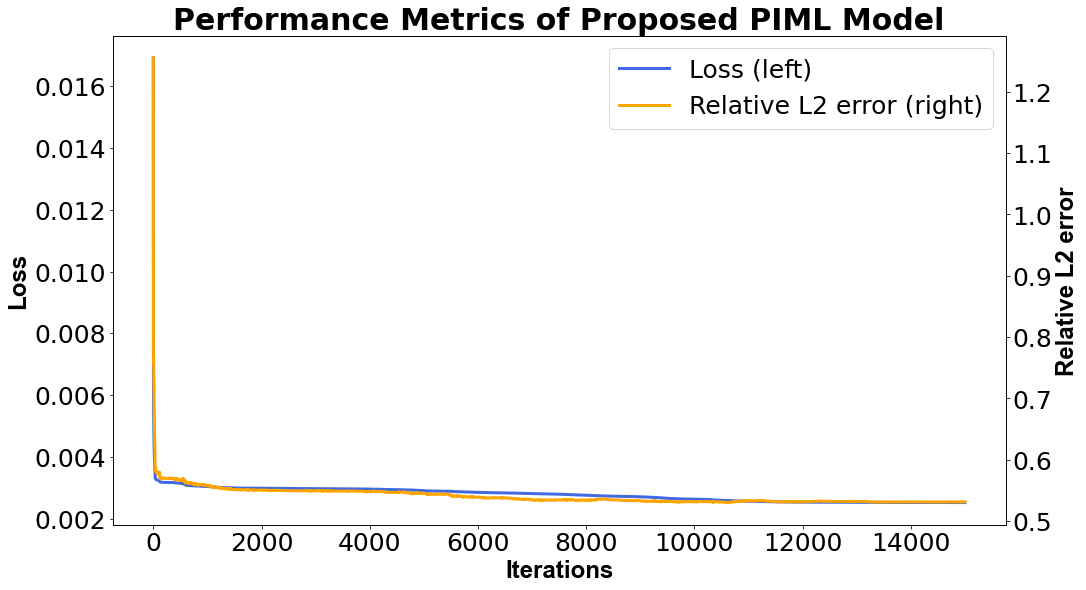

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020921668633547958
MSE =  0.003087030751258466
RMSE =  0.055561054266981526
L2 relative error = 0.5178188426391768
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

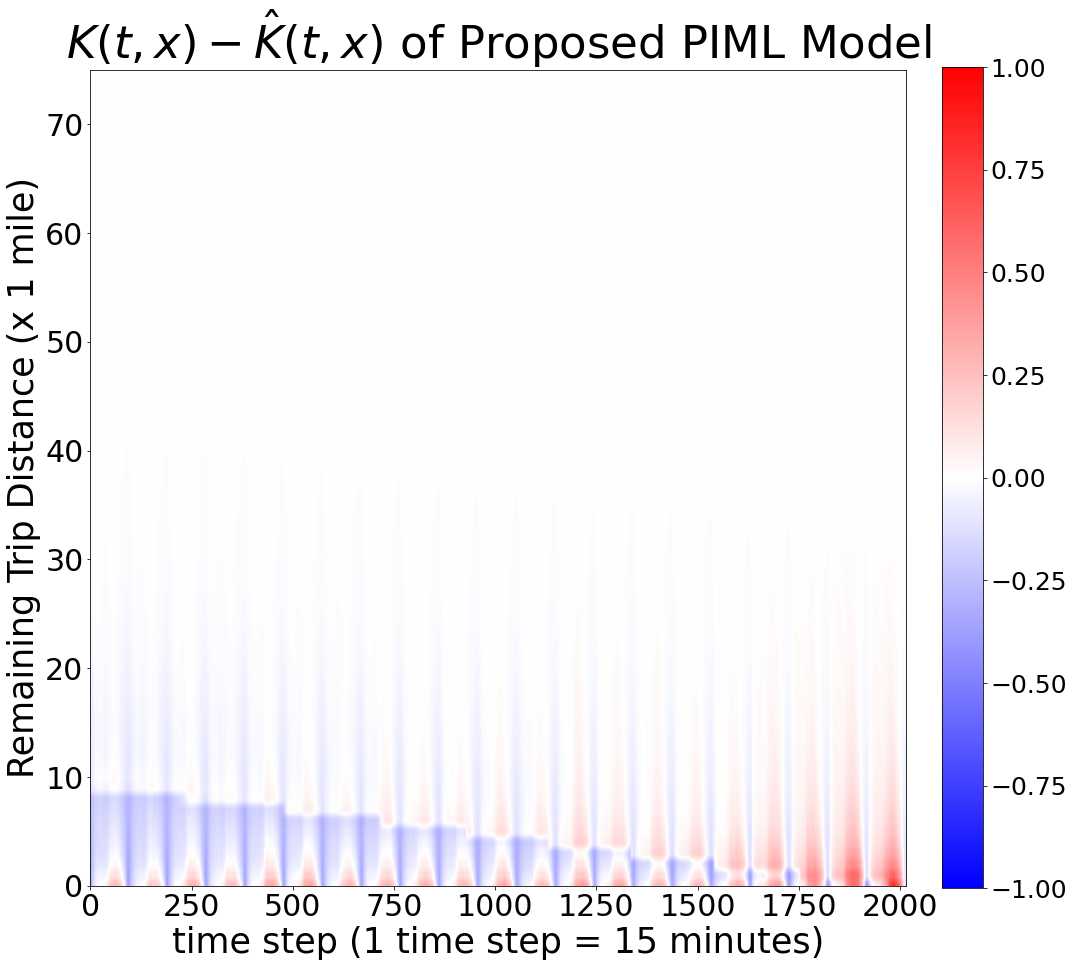

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

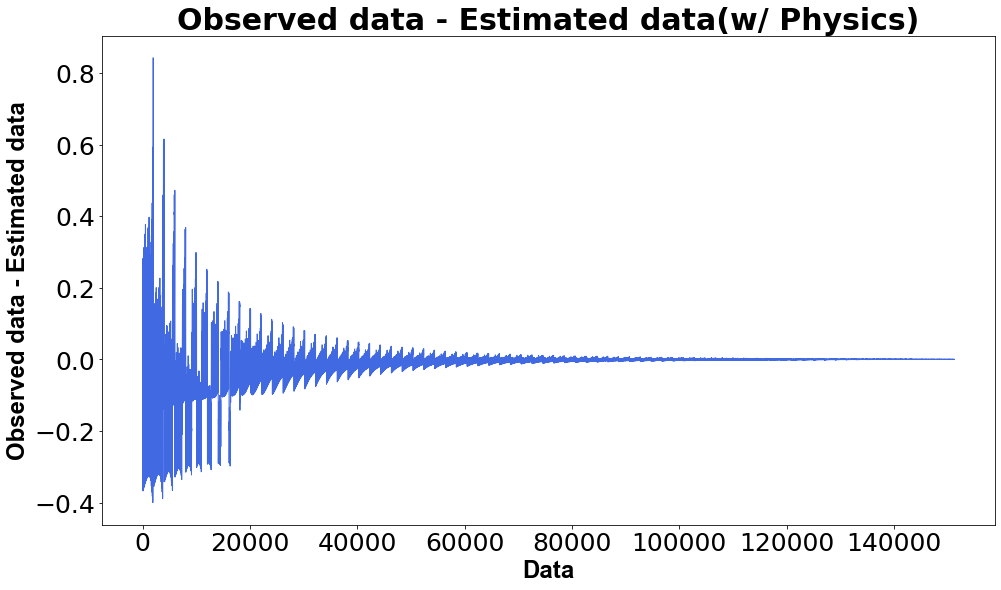

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

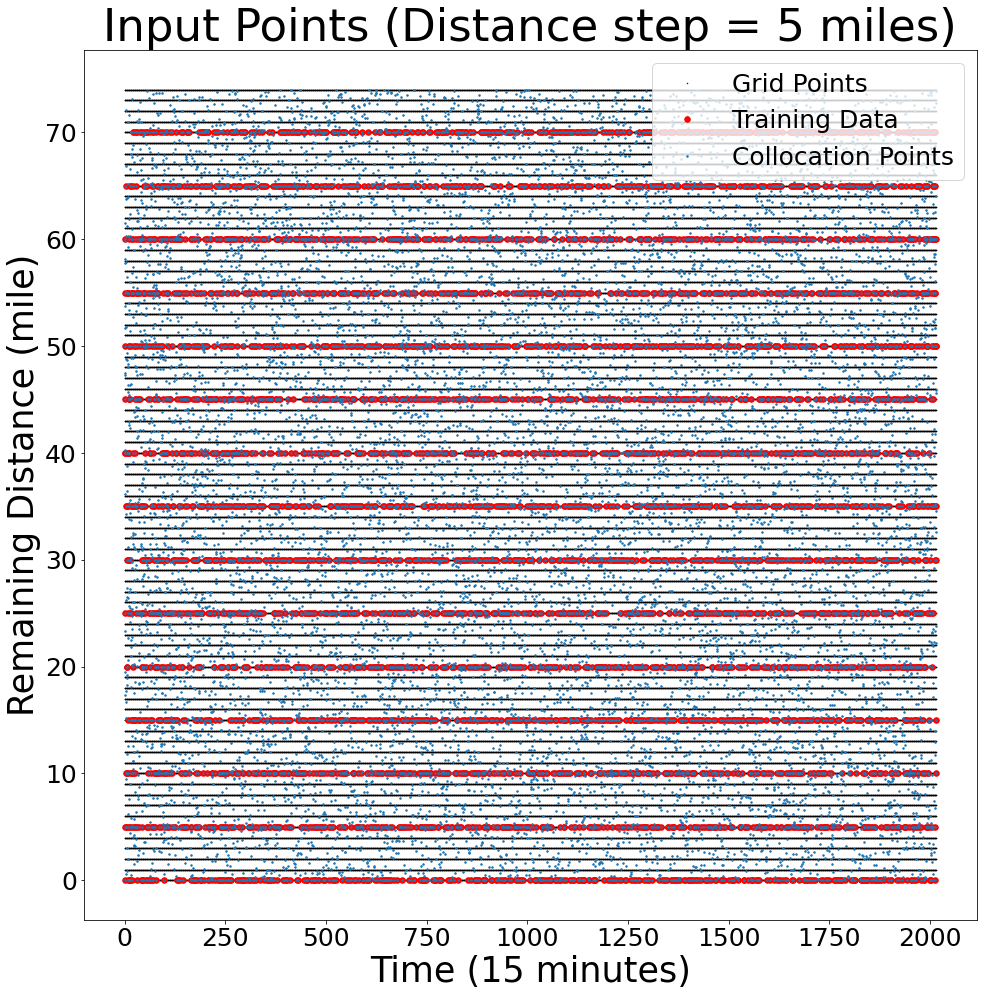

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

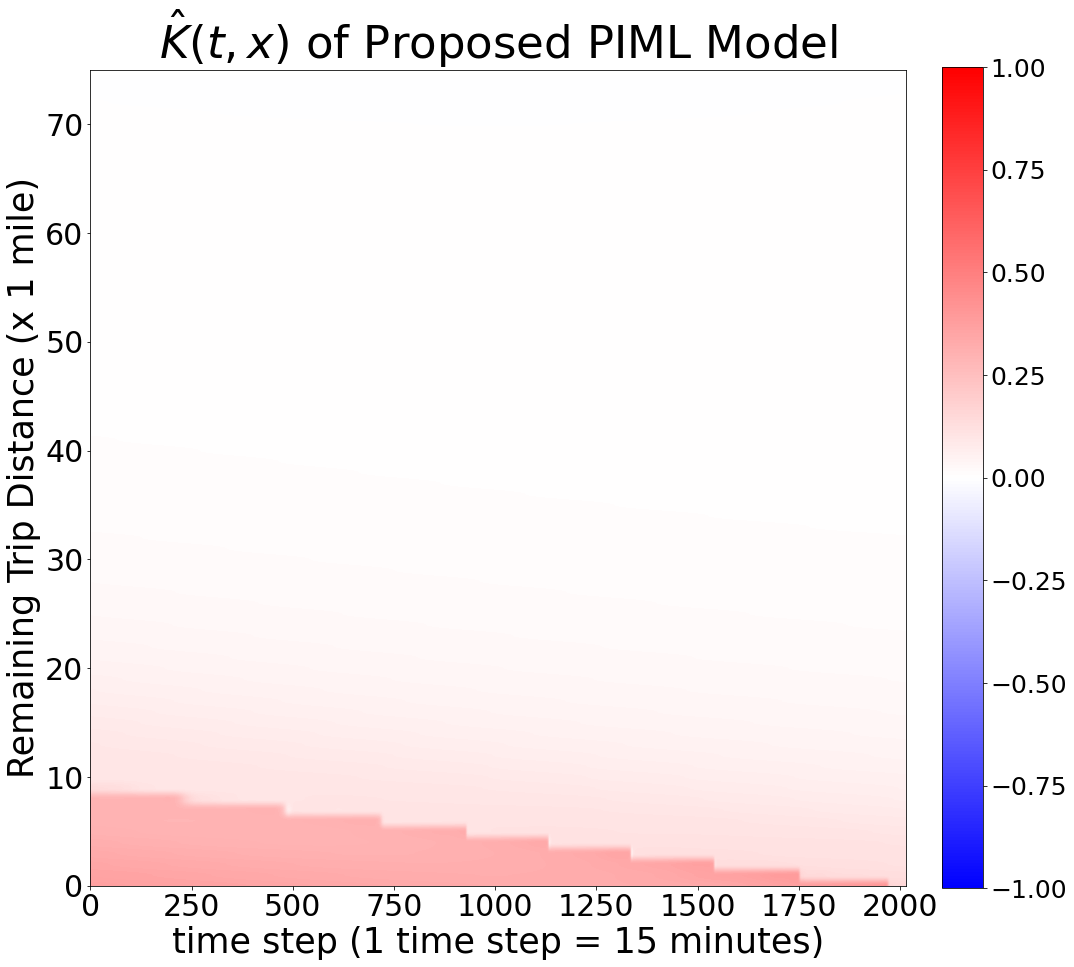

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)